# Overview

In this workshop, we will perform data analysis and apply machine learning techniques to real-world clinical data.
A dataset was constructed based on the code provided in https://github.com/YerevaNN/mimic3-benchmarks
for the prediction of hospital mortality using early ICU admission data. 
 
The data were extracted from the MIMIC-III Clinical Database, which is a large, publicly-available database comprising de-identified electronic health records of approximately 60 000 ICU admissions. Patients stayed in the intensive care unit (ICU) of the Beth Israel Deaconess Medical Center between 2001 and 2012. MIMIC-III database is described in:

> Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, Mark RG. MIMIC-III, a freely accessible critical care database. Scientific Data (2016).

The tutorial is divided in two main parts:

* **Patient stratification** through **unsupervised learning**
    * Time series trends partitioned by outcome
    * k-means clustering

* **Patient classification** through **supervised learning**
    * Feature selection
    * Logistic regression
    * Decision trees
    * Random forest

Note: Before you begin, you should install pydot and graphviz by running 

~~~~
sudo apt-get install python-pydot
sudo apt-get install graphviz
~~~~

This will allow you to create graphical decision trees.


# 1. Import the data

We will use the unique ICU stay ID as the dataframe index.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.style.use('ggplot')

data = pd.read_csv('/Users/catiasalgado/dataset.csv',index_col='icustay')

/Users/catiasalgado/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 2. Explore the data

In [2]:
display.display(data.head())
print()

diastolic BP  glasgow coma scale  glucose  heart rate     hours  \
icustay                                                                     
282372.0          60.0                 NaN      NaN       139.0  0.066667   
282372.0          73.0                 NaN      NaN       128.0  0.150000   
282372.0          81.0                 NaN      NaN       127.0  0.233333   
282372.0          86.0                 NaN      NaN       132.0  0.316667   
282372.0          86.0                 NaN      NaN       138.0  0.400000   

             mean BP  oxygen saturation  respiratory rate  systolic BP  \
icustay                                                                  
282372.0   84.666702              100.0              20.0        134.0   
282372.0   93.000000              100.0              25.0        133.0   
282372.0   88.666702              100.0              22.0        104.0   
282372.0  100.000000              100.0              19.0        128.0   
282372.0  100.333000              100.0              21.0        129.0   

          temperature        age  gender  height  mortality  pH  weight  day  
icustay                                                                       
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1

The dataset contains information regarding:

* Patient demographics
    * age
    * gender
    * weight
    * height
    * mortality
    
* Physiological vital signs
    * diastolic blood pressure
    * systolic blood pressure
    * mean blood pressure
    * temperature
    * respiratory rate
    
* Lab Tests
    * Chemistry 
        * glucose
    * Arterial blood gases (ABGs)
        * pH

* Scores
    * glasgow coma scale
    
Each measurement is associated with a time stamp (column 'hours'), indicating the number of hours since ICU admission where the measurement was taken.
    
Now lets see some summary statistics.

In [3]:
print('Number of ICU stays: ' + str(len(data.index.unique())))
df = data.groupby(['icustay']).mean()
print('Number of survivors: ' + str(df[df['mortality'] == 0].count()['mortality']))
print('Number of non-survivors: ' + str(df[df['mortality'] == 1].count()['mortality']))
print('Mortality: ' + str(round(100*df[df['mortality'] == 1].sum()['mortality'] / len(data.index.unique()),1)) + '%')
print()
display.display(data.info(null_counts=1))
display.display(data.describe())

Number of ICU stays: 21140
Number of survivors: 18342
Number of non-survivors: 2797
Mortality: 13.2%

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1730668 entries, 282372.0 to nan
Data columns (total 17 columns):
diastolic BP          1195941 non-null float64
glasgow coma scale    187570 non-null float64
glucose               293604 non-null float64
heart rate            1255963 non-null float64
hours                 1730668 non-null float64
mean BP               1187689 non-null float64
oxygen saturation     1265732 non-null float64
respiratory rate      1266816 non-null float64
systolic BP           1196430 non-null float64
temperature           379653 non-null float64
age                   1461282 non-null float64
gender                1461282 non-null float64
height                455361 non-null float64
mortality             1730668 non-null int64
pH                    146147 non-null float64
weight                1309930 non-null float64
day                   1730668 non-n

None

diastolic BP  glasgow coma scale        glucose    heart rate  \
count  1.195941e+06       187570.000000  293604.000000  1.255963e+06   
mean   6.118764e+01           11.608514     147.421184  8.684657e+01   
std    2.477219e+02            3.914011    1846.627000  1.970154e+01   
min   -1.300000e+01            3.000000       0.000000  0.000000e+00   
25%    5.100000e+01            9.000000     106.000000  7.400000e+01   
50%    5.900000e+01           14.000000     129.000000  8.500000e+01   
75%    6.800000e+01           15.000000     162.000000  9.800000e+01   
max    1.141090e+05           15.000000  999999.000000  6.632000e+03   

              hours       mean BP  oxygen saturation  respiratory rate  \
count  1.730668e+06  1.187689e+06       1.265732e+06      1.266816e+06   
mean   2.188633e+01  7.850657e+01       9.759810e+01      2.104548e+01   
std    1.419493e+01  1.360455e+02       8.721160e+02      2.092837e+03   
min    0.000000e+00 -3.700000e+01       0.000000e+00      0.000000e+00   
25%    9.031389e+00  6.700000e+01       9.600000e+01      1.500000e+01   
50%    2.099778e+01  7.600000e+01       9.800000e+01      1.900000e+01   
75%    3.410000e+01  8.700000e+01       1.000000e+02      2.300000e+01   
max    4.800000e+01  1.171200e+05       9.810230e+05      2.355555e+06   

        systolic BP    temperature           age        gender         height  \
count  1.196430e+06  379653.000000  1.461282e+06  1.461282e+06  455361.000000   
mean   1.196717e+02      37.008739  6.535809e+01  1.554603e+00     169.170224   
std    2.840454e+01       8.913396  1.663225e+01  4.970097e-01      14.552301   
min    0.000000e+00      -3.000000  1.803403e+01  1.000000e+00       0.000000   
25%    1.030000e+02      36.444444  5.474257e+01  1.000000e+00     163.000000   
50%    1.170000e+02      37.000000  6.738069e+01  2.000000e+00     170.000000   
75%    1.340000e+02      37.555556  7.862746e+01  2.000000e+00     178.000000   
max    1.375600e+04    5336.111111  9.000000e+01  2.000000e+00     445.000000   

          mortality             pH        weight           day  
count  1.730668e+06  146147.000000  1.309930e+06  1.730668e+06  
mean   1.451474e-01       7.277576  8.280987e+01  1.441219e+00  
std    3.522495e-01       2.186084  2.575886e+01  4.965329e-01  
min    0.000000e+00       0.000000  0.000000e+00  1.000000e+00  
25%    0.000000e+00       7.310000  6.650000e+01  1.000000e+00  
50%    0.000000e+00       7.370000  7.910000e+01  1.000000e+00  
75%    0.000000e+00       7.420000  9.440000e+01  2.000000e+00  
max    1.000000e+00     733.000000  9.312244e+02  2.000000e+00

There are 21,140 unique ICU stays and 1,730,668 observations. 

All variables except 'hours', 'mortality' and 'day' have missing information.

Outliers can already be spotted (e.g. max glucose).

## 2.1. Variable selection

### 2.1.1. Aggregate data by ICU stay and look at the number of non-null values
This will give an indication of how many ICU stays have at least one measurement per variable.

In [4]:
print(data.groupby(['icustay']).mean().info(null_counts=1))

<class 'pandas.core.frame.DataFrame'>
Float64Index: 21139 entries, 200001.0 to 299995.0
Data columns (total 17 columns):
diastolic BP          19154 non-null float64
glasgow coma scale    10993 non-null float64
glucose               18745 non-null float64
heart rate            19282 non-null float64
hours                 21139 non-null float64
mean BP               19123 non-null float64
oxygen saturation     19305 non-null float64
respiratory rate      19367 non-null float64
systolic BP           19154 non-null float64
temperature           18440 non-null float64
age                   21139 non-null float64
gender                21139 non-null float64
height                5370 non-null float64
mortality             21139 non-null float64
pH                    15489 non-null float64
weight                18181 non-null float64
day                   21139 non-null float64
dtypes: float64(17)
memory usage: 2.9 MB
None


### 2.1.2. Select variables 

There should be a trade-off between the potential value of the variable in the model and the amount of data available. 

* Height can be discarded due to the high amount of missing data

* Weight and height are typically used combined (body mass index), therefore weight can also be discarded.

* The other variables we will keep. Let's start with time-variant variables and set aside age and gender for now.

In [5]:
variables = ['diastolic BP', 'glasgow coma scale',
             'glucose', 'heart rate', 'mean BP',
             'oxygen saturation', 'respiratory rate', 'systolic BP',
             'temperature', 'pH']
variables_mort = variables.copy()
variables_mort.append('mortality')

# 3. Data preprocessing
## 3.1. Outliers
### 3.1.1. Visualize data

We already saw that there are outliers in the data. Let's have a closer look at this.

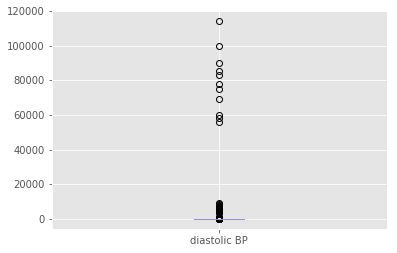

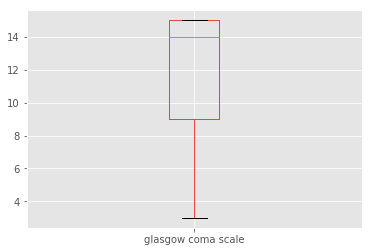

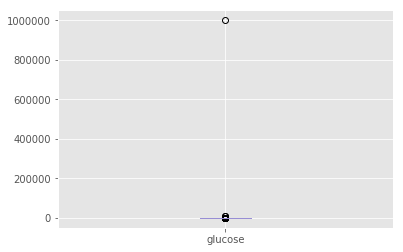

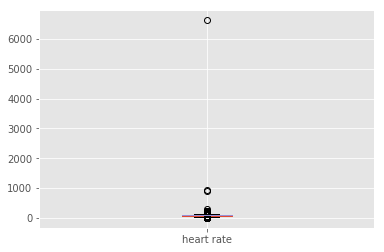

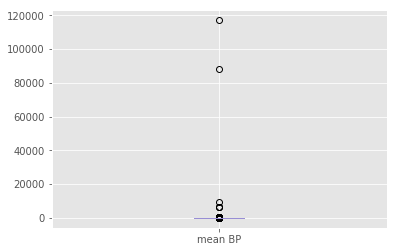

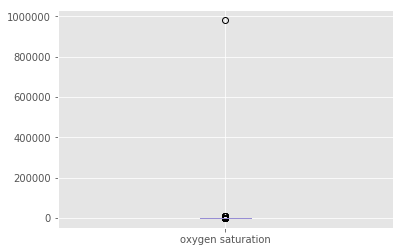

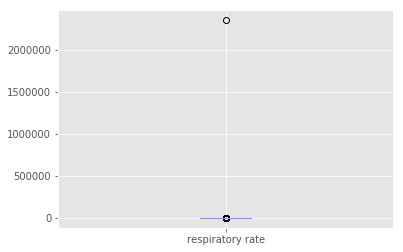

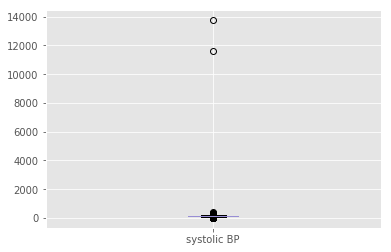

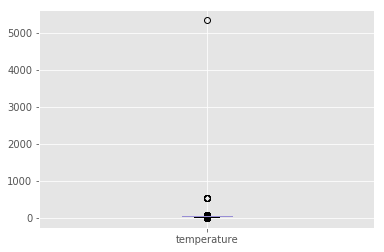

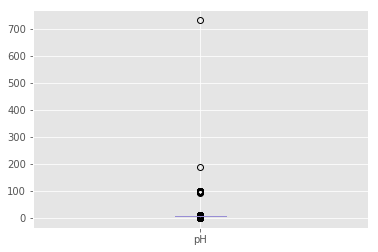

In [6]:
for variable in data[variables]:
    data[variable].plot.box()
    plt.show()

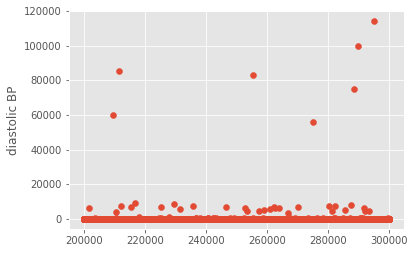

In [7]:
variable = 'diastolic BP'
plt.scatter(data.index, data[variable])
plt.ylabel(variable)
plt.show()

### 3.1.2. Choose method to deal with outliers

Ideally, we should keep extreme values related to the poor health condition of patients, and discard impossible values (such as negative temperature) and probable outliers (such as heart rate above 250 beats/min). In order to do so, we will remove values that fall outside boudaries defined by expert knowledge. This will avoid discarding extreme (but correct/possible) values.


In [8]:
nulls_before = data.isnull().sum().sum()

data.loc[data['diastolic BP']>300, 'diastolic BP'] = np.nan
data.loc[data['glucose']>2000, 'glucose'] = np.nan
data.loc[data['heart rate']>400, 'heart rate'] = np.nan
data.loc[data['mean BP']>300, 'mean BP'] = np.nan
data.loc[data['mean BP']<0, 'mean BP'] = np.nan
data.loc[data['systolic BP']>10000,  'systolic BP'] = np.nan
data.loc[data['temperature']>50, 'temperature'] = np.nan
data.loc[data['temperature']<20, 'temperature'] = np.nan
data.loc[data['pH']>7.8, 'pH'] = np.nan
data.loc[data['pH']<6.8, 'pH'] = np.nan
data.loc[data['respiratory rate']>300, 'respiratory rate'] = np.nan
data.loc[data['oxygen saturation']>100, 'oxygen saturation'] = np.nan
data.loc[data['oxygen saturation']<0, 'oxygen saturation'] = np.nan

nulls_now = data.isnull().sum().sum()
print('Number of outliers removed: ' + str(nulls_now - nulls_before))


Number of outliers removed: 9213


### 3.1.3. Visualize data after outliers removal

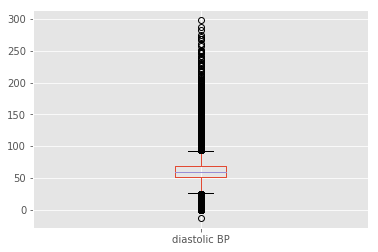

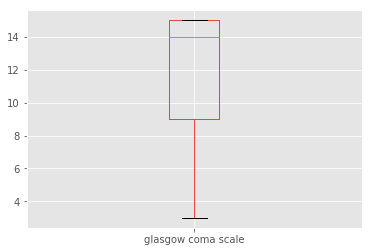

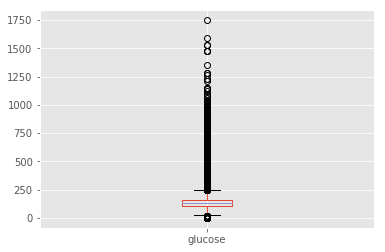

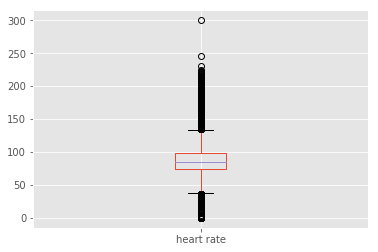

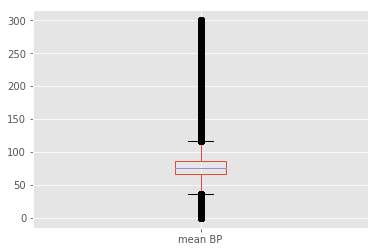

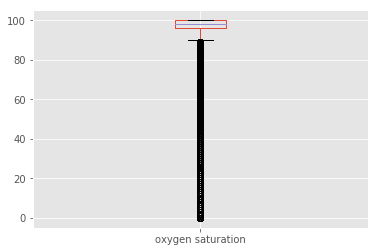

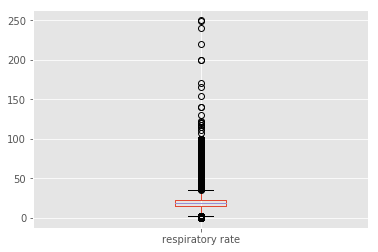

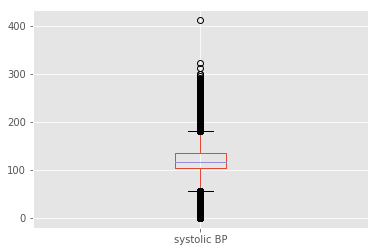

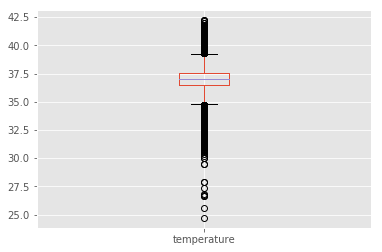

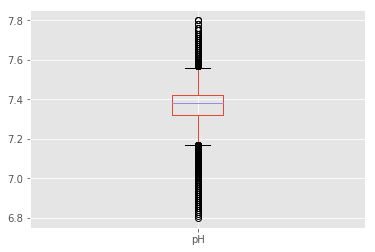

In [9]:
for variable in data[variables]:
    data[variable].plot.box()
    plt.show()

## 3.2. Aggregate data by hour

To allow for ease of comparison, individual data is condensed into hourly measurements by selecting the median value of the available measurements within each hour.

In [10]:
data['hour'] = data['hours'].apply(np.floor)
# data goes until h = 48
data.loc[data['hour'] == 48, 'hour'] = 47
data_median_hour = data.groupby(['icustay','hour'])[variables_mort].median()
# dataframe is multindex (icustay and hour)

# go back to icustay index
icustays = data_median_hour.index.get_level_values(0)
data_median_hour['hour'] = data_median_hour.index.get_level_values(1)
data_median_hour = data_median_hour.set_index(icustays)
display.display(data_median_hour.tail())

diastolic BP  glasgow coma scale  glucose  heart rate  mean BP  \
icustay                                                                    
299995.0           NaN                15.0      NaN         NaN      NaN   
299995.0          82.0                 NaN      NaN        74.0     93.0   
299995.0           NaN                 NaN      NaN        72.0      NaN   
299995.0           NaN                 NaN      NaN        82.0      NaN   
299995.0          65.0                15.0      NaN        73.0     81.0   

          oxygen saturation  respiratory rate  systolic BP  temperature  pH  \
icustay                                                                       
299995.0                NaN               NaN          NaN          NaN NaN   
299995.0                NaN              19.0        145.0          NaN NaN   
299995.0                NaN              20.0          NaN          NaN NaN   
299995.0                NaN              20.0          NaN          NaN NaN   
299995.0                NaN              20.0        128.0    36.555599 NaN   

          mortality  hour  
icustay                    
299995.0          0  42.0  
299995.0          0  43.0  
299995.0          0  44.0  
299995.0          0  45.0  
299995.0          0  46.0

## 3.3. Select minimum number of measurements

We already decided to keep all the time-variant variables in our dataset. That means we have to discard patients who don't have enough information in any of the variables. One possible approach is to say that we will use all patients who have at least one measurement per variable. But we will be more conservative and say that we want at least two measurements per variable in our dataset. 

In the following function, setting 'min_num_meas = 2' means that we are selecting ICU stays where each variable was recorded at least once at two different hours.

In [11]:
# Select stays where there are at least 'min_num_meas' measurements.
min_num_meas = 2

def extr_min_num_meas(data_median_hour, min_num_meas):
    data_count = data_median_hour.groupby(['icustay'])[variables_mort].count()
    #print(data_count.head())
    #print(data_count.describe())

    for col in data_count:
        data_count[col] = data_count[col].apply(lambda x: np.nan if x < min_num_meas else x)

    data_count = data_count.dropna(axis=0, how='any')
    print('Number of ICU stays: ' + str(data_count.shape[0]))
    print('Number of features: ' + str(data_count.shape[1]))
    unique_stays = data_count.index.unique()

    data_median_hour = data_median_hour.loc[unique_stays]
    
    return data_median_hour

data_median_hour = extr_min_num_meas(data_median_hour, min_num_meas)

Number of ICU stays: 6931
Number of features: 11


As you may notice, we started with a database of around 60,000 ICU stays, imported a fraction of those that satisfied some criteria, in a total of 21,140 ICU stays, and are now looking at 6,931 ICU stays.

# 4. Explore the preprocessed data
## 4.1. Multivariate ploting
Plot pairwise relationships in the dataset, grouped by outcomes.

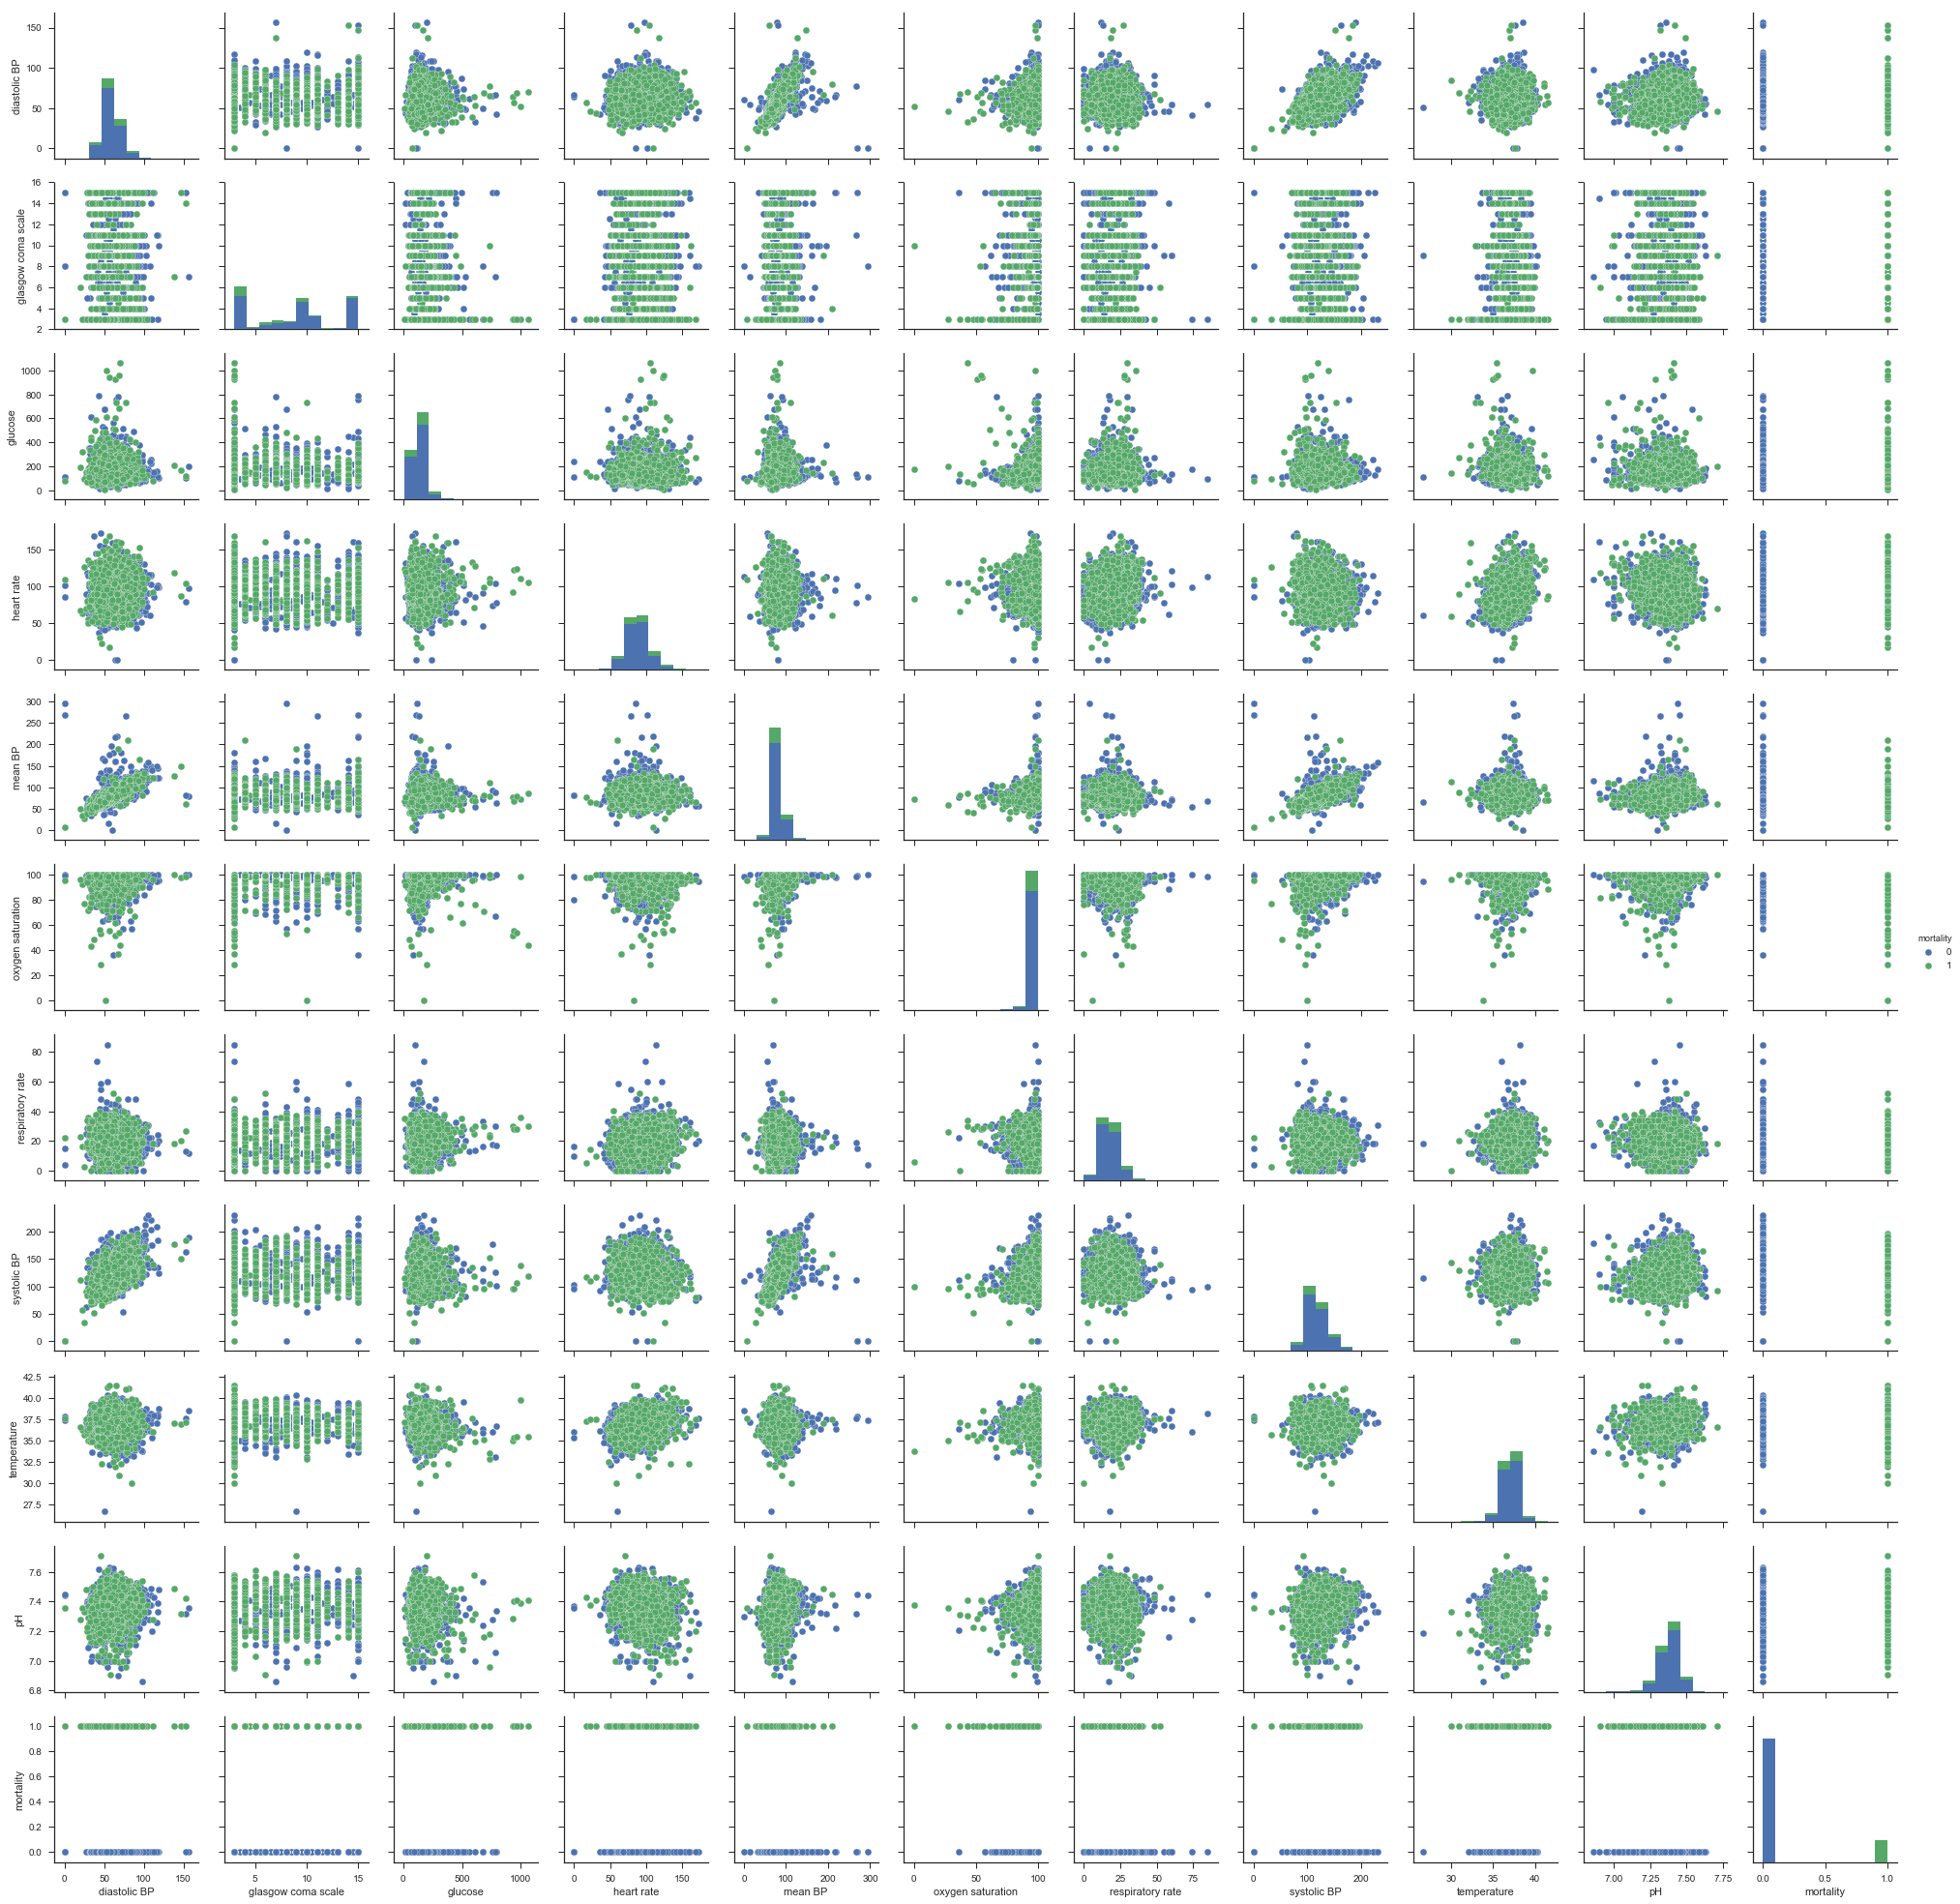

In [12]:
import seaborn as sns

sns.set(style="ticks")
sns.pairplot(data_median_hour[variables_mort].dropna(axis=0, how='any'), hue = 'mortality')
plt.show()

# change back to our preferred style
plt.style.use('ggplot')

Not much to see here. 

Reality check: diastolic blood pressure and mean blood pressure are positively correlated.

## 4.2. Time series ploting

Let's investigate time trends partitioned by outcome.

### 4.2.1. Organize the dataset

In [13]:
def timeseries_data(data_median_hour, variable, filldata = 1):
    """Return matrix of time series data for clustering,
    with rows corresponding to unique observations (ICU stays) and 
    columns corresponding to time since ICU admission"""
    data4clustering = data_median_hour.pivot(columns='hour', values=variable)
    if filldata == 1:
        # first forward fill
        data4clustering = data4clustering.fillna(method='ffill', axis=1)
        # next backward fill
        data4clustering = data4clustering.fillna(method='bfill', axis=1)
        data4clustering = data4clustering.dropna(axis=0, how='all')
    return data4clustering

### 4.2.2. Plot mean values partitioned by outcome

Do not fill missing data at this point.

Plotting 308913 observations from 6931 ICU stays


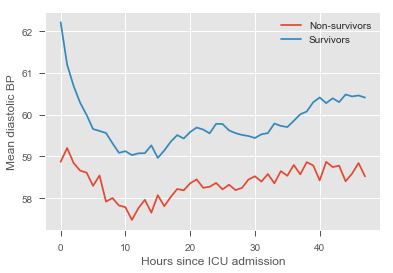

Plotting 107073 observations from 6931 ICU stays


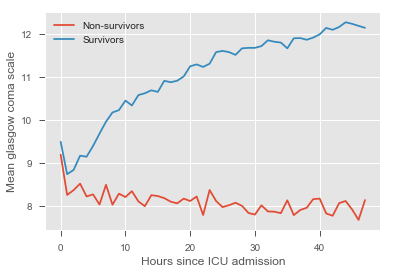

Plotting 99885 observations from 6931 ICU stays


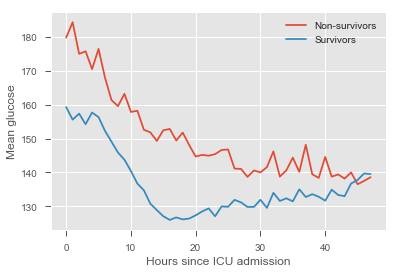

Plotting 310930 observations from 6931 ICU stays


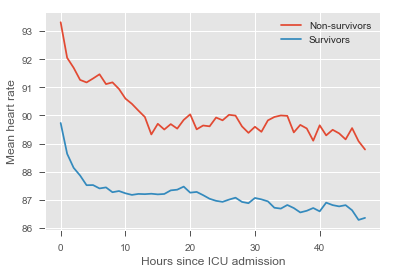

Plotting 306827 observations from 6931 ICU stays


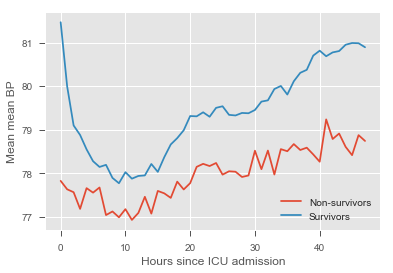

Plotting 302563 observations from 6931 ICU stays


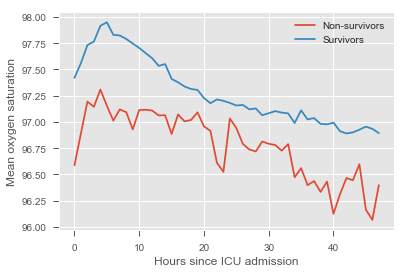

Plotting 305363 observations from 6931 ICU stays


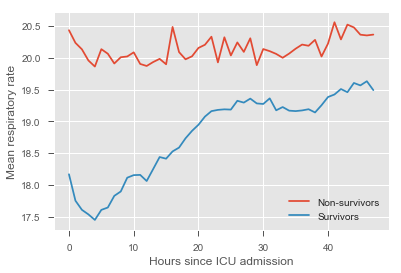

Plotting 308942 observations from 6931 ICU stays


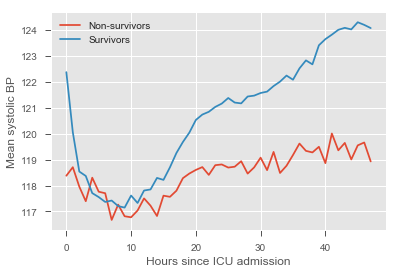

Plotting 138124 observations from 6931 ICU stays


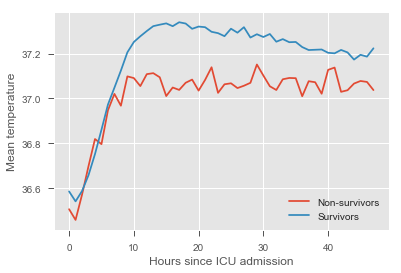

Plotting 60375 observations from 6931 ICU stays


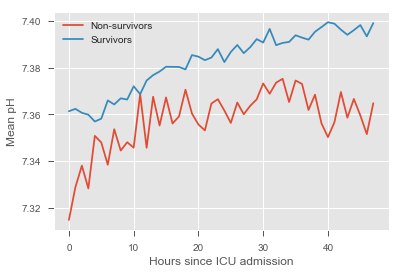

In [14]:
for variable in variables:
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 0)
    print('Plotting ' + str(data4clustering.count().sum()) + ' observations from ' + str(data4clustering.shape[0]) + ' ICU stays')
    mortality = data.loc[data4clustering.index]['mortality'].groupby(['icustay']).mean()
    data4clustering_mort = pd.concat([data4clustering, mortality], axis = 1)
    class1 = data4clustering_mort[data4clustering_mort['mortality']==1].drop(columns = ['mortality']).mean()
    class0 = data4clustering_mort[data4clustering_mort['mortality']==0].drop(columns = ['mortality']).mean()
    plt.figure()
    plt.plot(class1)
    plt.plot(class0)
    plt.grid(b=True, which='major')
    plt.xlabel('Hours since ICU admission')
    plt.ylabel('Mean ' + variable)
    plt.legend(['Non-survivors', 'Survivors'])
    plt.show()


We can see clear distinctions between the groups.

* **diastolic BP**
    * higher in the survival group
    * rapidly decreasing during the first 10 hours, especially in the survival group, and incresing at a lower rate thereafter
    
* **glasgow coma scale**
    * higher in the survival group, increasing over time
    * steady around 8 in the non-survival group
    * similar between both groups at admission, but diverging thereafter
    
* **glucose**
    * decreasing over time in both groups
    
* **heart rate**
    * lower in the survival group
    
* **mean BP** - similar to diastolic BP

* **oxygen saturation**
    * higher in the survival group
    * low variation from t=0 to t=48h
 
* **respiratory rate**
    * lower in the survival group, slowly increasing over time
    * steady around 20 in the non-survival group

* **systolic BP** - similar to diastolic and mean BP

* **temperature**
    * low variation from t=0 to t=48h
    * slightly increasing during the first 10 hours
    
* **pH**
    * Increasing over time in both groups
    * pH < 7.35 (associated with metabolic acidosis) during the first 10 hours in the non-survival group
    
    
# 5. Feature engineering
## 5.1. Feature construction

Feature construction addresses the problem of finding the transformation of variables containing the greatest amount of useful information. We will use simple operations to construct/extract important features from the time series:

* Maximum
* Minimum
* Standard deviation
* Mean

These features will summarize the worst, best, variation and average patient' condition from t=0 to t=48h, according to each variable. In the proposed exercises you will do this for each day separately, which will increase the dataset dimensionality but hopefully will allow the extraction of more useful information.

In [15]:
def feat_transf(data):
    data_max = data.groupby(['icustay'])[variables].max()
    data_max.columns = ['max ' + str(col) for col in data_max.columns]

    data_min = data.groupby(['icustay'])[variables].min()
    data_min.columns = ['min ' + str(col) for col in data_min.columns]
    
    data_sd = data.groupby(['icustay'])[variables].std()
    data_sd.columns = ['sd ' + str(col) for col in data_sd.columns]

    data_mean = data.groupby(['icustay'])[variables].mean()
    data_mean.columns = ['mean ' + str(col) for col in data_mean.columns]

    data_agg = pd.concat([data_min,data_max,data_sd,data_mean],axis=1)
    
    return data_agg

data_transf = feat_transf(data_median_hour)
print('Extracted features: ')
display.display(list(data_transf.columns))
print('')
print('Number of ICU stays: ' + str(data_transf.shape[0]))
print('Number of features: ' + str(data_transf.shape[1]))
display.display(data_transf.head())


Extracted features: 


['min diastolic BP',
 'min glasgow coma scale',
 'min glucose',
 'min heart rate',
 'min mean BP',
 'min oxygen saturation',
 'min respiratory rate',
 'min systolic BP',
 'min temperature',
 'min pH',
 'max diastolic BP',
 'max glasgow coma scale',
 'max glucose',
 'max heart rate',
 'max mean BP',
 'max oxygen saturation',
 'max respiratory rate',
 'max systolic BP',
 'max temperature',
 'max pH',
 'sd diastolic BP',
 'sd glasgow coma scale',
 'sd glucose',
 'sd heart rate',
 'sd mean BP',
 'sd oxygen saturation',
 'sd respiratory rate',
 'sd systolic BP',
 'sd temperature',
 'sd pH',
 'mean diastolic BP',
 'mean glasgow coma scale',
 'mean glucose',
 'mean heart rate',
 'mean mean BP',
 'mean oxygen saturation',
 'mean respiratory rate',
 'mean systolic BP',
 'mean temperature',
 'mean pH']


Number of ICU stays: 6931
Number of features: 40


min diastolic BP  min glasgow coma scale  min glucose  \
icustay                                                           
200003.0              47.0                     5.0         90.0   
200019.0              30.0                     6.0        117.0   
200045.0              16.0                     3.0         18.0   
200059.0              52.0                    10.0        121.0   
200102.0              35.5                     3.0        117.0   

          min heart rate  min mean BP  min oxygen saturation  \
icustay                                                        
200003.0            66.0    55.000000                   91.5   
200019.0            42.0    64.333298                   95.0   
200045.0            64.0    49.333302                   90.0   
200059.0            64.5    65.000000                   93.0   
200102.0            64.0    50.000000                   88.5   

          min respiratory rate  min systolic BP  min temperature  min pH  \
icustay                                                                    
200003.0                   0.0             82.0        36.388901    7.36   
200019.0                  11.0            129.0        36.166698    7.36   
200045.0                   2.0            104.0        36.111111    7.19   
200059.0                  10.5             89.0        33.055599    7.37   
200102.0                   4.0             84.0        35.300001    7.34   

            ...     mean diastolic BP  mean glasgow coma scale  mean glucose  \
icustay     ...                                                                
200003.0    ...             61.446809                10.538462    125.750000   
200019.0    ...             48.829545                 7.769231    139.300000   
200045.0    ...             47.958333                12.000000    171.714286   
200059.0    ...             68.712766                10.250000    166.062500   
200102.0    ...             51.000000                 7.227273    174.521739   

          mean heart rate  mean mean BP  mean oxygen saturation  \
icustay                                                           
200003.0        86.744681     75.138298               96.819149   
200019.0        54.922222     88.499998               99.255556   
200045.0        87.083333     75.645842               97.512195   
200059.0        93.728261     91.553191               99.788889   
200102.0        78.156250     69.458333               95.437500   

          mean respiratory rate  mean systolic BP  mean temperature   mean pH  
icustay                                                                        
200003.0              23.130435        104.159574         37.491236  7.419444  
200019.0              20.122222        167.909091         37.310201  7.370000  
200045.0              21.936170        130.062500         36.663600  7.281429  
200059.0              14.776596        131.861702         36.375740  7.413333  
200102.0              18.687500        115.156250         36.085660  7.382222  

[5 rows x 40 columns]

We just obtained a matrix containing one row per ICU stay. We are one step closer to building our models. Great!

Note that if we were to put all time series values together without performing this step, we would have $48 \text{hours}\times 11 \text{variables}=528$ features.

## 5.2. Add time invariant data

We can now add the time invariant information to our dataset.

In [16]:
mortality = data.loc[data_transf.index]['mortality'].groupby(['icustay']).mean()
age = data.loc[data_transf.index]['age'].groupby(['icustay']).mean()
# weight = data.loc[data_transf.index]['weight'].groupby(['icustay']).mean()
gender = data.loc[data_transf.index]['gender'].groupby(['icustay']).mean()

data_transf_inv = pd.concat([data_transf, age, mortality], axis=1).dropna(axis=0)
print('Number of ICU stays: ' + str(data_transf_inv.shape[0]))
print('Number of features: ' + str(data_transf_inv.shape[1]))

Number of ICU stays: 6931
Number of features: 42


# 6. Data partitioning

Splitting the data into training and test sets.

Questions to have in mind:

* a highly imbalanced training set will lead to biased estimations

* the test set needs to have a real representation of class labels, i.e., if data is split randomly, the test set might have input categories that never appear in the training set (not a big deal for big data)

In [17]:
from sklearn.cross_validation import train_test_split

def data_partioning(data_transf_inv, test_size, perc_class1, print_):
    """Divide the data into training and test sets. 
    Use test_size to select the % of observations in the test set.
    If perc_class1 is given, undersampling is performed in order to have a balanced training set. 
    Use print_ = 1 to print the number of observations and class distribution in each set."""

    X_train, X_test, y_train, y_test = train_test_split(data_transf_inv, data_transf_inv[['mortality']], test_size = test_size, random_state = 10)
    if print_ == 1:
        if perc_class1:
            print('Before balancing')
        print(str(len(y_train[y_train['mortality']==1])) + '(' + str(round(len(y_train[y_train['mortality']==1])/len(y_train)*100,2)) + '%)' + ' non-survivors in training set')
        print(str(len(y_train[y_train['mortality']==0])) + '(' + str(round(len(y_train[y_train['mortality']==0])/len(y_train)*100,2)) + '%)' + ' survivors in training set')
        print(str(len(y_test[y_test['mortality']==1])) + '(' + str(round(len(y_test[y_test['mortality']==1])/len(y_test)*100,2)) + '%)' + ' non-survivors in test set')
        print(str(len(y_test[y_test['mortality']==0])) + '(' + str(round(len(y_test[y_test['mortality']==0])/len(y_test)*100,2)) + '%)' + ' survivors in test set')
        print()
        
    # Apply the random under-sampling
    class0_indices = y_train[y_train['mortality'] == 0].index
    class1_indices = y_train[y_train['mortality'] == 1].index
    if perc_class1:
        class0_size = round(np.int((len(y_train[y_train['mortality'] == 1])*(1 - perc_class1)) / perc_class1),0)
    
        random_indices = np.random.choice(class0_indices, class0_size, replace=False)
        X_train_0 = X_train.loc[random_indices]
        y_train_0 = y_train.loc[random_indices]
        X_train_1 = X_train.loc[class1_indices]
        y_train_1 = y_train.loc[class1_indices]
        X_train = pd.concat([X_train_0,X_train_1])
        y_train = pd.concat([y_train_0,y_train_1])

        if print_ == 1:
            print()
            print('After balancing')
            print(str(len(y_train[y_train['mortality']==1])) + '(' + str(round(len(y_train[y_train['mortality']==1])/len(y_train)*100,2)) + '%)' + ' non-survivors in training set')
            print(str(len(y_train[y_train['mortality']==0])) + '(' + str(round(len(y_train[y_train['mortality']==0])/len(y_train)*100,2)) + '%)' + ' survivors in training set')
            print(str(len(y_test[y_test['mortality']==1])) + '(' + str(round(len(y_test[y_test['mortality']==1])/len(y_test)*100,2)) + '%)' + ' non-survivors in test set')
            print(str(len(y_test[y_test['mortality']==0])) + '(' + str(round(len(y_test[y_test['mortality']==0])/len(y_test)*100,2)) + '%)' + ' survivors in test set')
            print()

    X_train = X_train.drop(columns = 'mortality')
    X_test = X_test.drop(columns = 'mortality')
    
    return X_train, X_test, y_train, y_test

/Users/catiasalgado/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
# select the test size and percentage of class 1 samples to be present in the training set
perc_class1 = 0.4
test_size = 0.2
print_ = 1

X_train, X_test, y_train, y_test = data_partioning(data_transf_inv, test_size, perc_class1, print_)

Before balancing
941(16.97%) non-survivors in training set
4603(83.03%) survivors in training set
246(17.74%) non-survivors in test set
1141(82.26%) survivors in test set


After balancing
941(40.01%) non-survivors in training set
1411(59.99%) survivors in training set
246(17.74%) non-survivors in test set
1141(82.26%) survivors in test set



# 7. Clustering

Clustering is a learning task that aims at decomposing a given set of observations into subgroups (clusters), based on data similarity, such that observations in the same cluster are more closely related to each other than observations in different clusters. It is an unsupervised learning task, since it identifies structures in unlabeled datasets, and a classification task, since it can give a label to observations according to the cluster they are assigned to.

In this workshop we focus on the questions:

* Can we identify distinct patterns even if the class labels are not provided? 

* How are the different patterns represented across different outcomes?

7.1. K-means clustering algorithm

7.2. Exemplification with 2D data

7.3. Time series clustering 

7.4. Normalize data

7.5. Concatenate predicted clustering labels with input data

## 7.1. K-means clustering algorithm

Consider a (training) dataset composed of $N$ observations:

$$
\begin{aligned}
x_1, x_2,..., x_N
\end{aligned}
$$

Initialize K centroids $\mu_1, \mu_2, ..., \mu_K$ randomly.

Repeat until convergence:

1. Cluster assignment <br>
> Assign each $x_i$ to the nearest cluster.<br>
> For every $i$ do: <br>
<center>
    $\underset{j}{argmin}\left \| x_i-\mu_j \right \|^2,$
</center>
> where $j=1,2,...,K$

1. Cluster updating <br>
> Update the cluster centroids $\mu_j$.<br>
> For every $j$ do:
<center>
$\mu_j = \frac{1}{N_j}\left [ x_1^j + x_2^j + ... + x_{N_j}^j \right ],$
</center>
> where $N_j$ is the number of observations assigned to cluster $j$, $k=1,2, ..., N_j$, and $x_k^j$ represents observation $k$ assigned to cluster $j$. <br>
> Each new centroid corresponds the mean of the observations assigned in the previous step.

## 7.2. Exemplification with 2D data

We did not see groups in pairwise plots, but some groups might have emerged after the data were transformed. 

You can re-run the code for pairwise plots between transformed features, but it will be time consuming due to the high dimensionality of the dataset. 

As an example, we will look at max mean BP and mean heart rate.


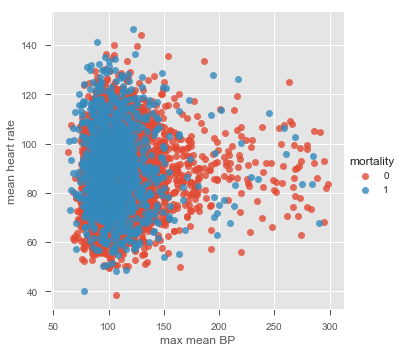

In [19]:
x1 = 'max mean BP'
x2 = 'mean heart rate'
sns.lmplot(x1, x2, data_transf_inv, hue="mortality", fit_reg=False);

The algorithm is implemented next. The number of clusters (K) must be provided. Here I chose 3.

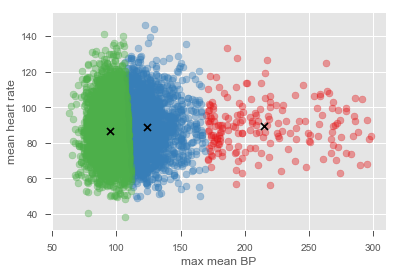

In [20]:
# http://jonchar.net/notebooks/k-means/
from sklearn.cluster import KMeans
import time
import pylab as pl
from IPython import display

K = 3
ground_truth = 'mortality'
X = pd.DataFrame.as_matrix(data_transf_inv[[x1,x2]])
mort = pd.DataFrame.as_matrix(data_transf_inv[ground_truth])

def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected points from points."""
    return points[np.random.randint(points.shape[0], size=k)]
    
# Function for calculating the distance between centroids
def get_distances(centroid, points):
    """Returns the distance the centroid is from each data point in points."""
    return np.linalg.norm(points - centroid, axis=1)

# Initialize our centroids by picking random data points
centroids = initialize_clusters(X, K)
centroids_old = np.zeros([K, X.shape[1]], dtype=np.float64)

# Initialize the vectors in which we will store the
# assigned classes of each data point and the
# calculated distances from each centroid
classes = np.zeros(X.shape[0], dtype=np.float64)
distances = np.zeros([X.shape[0], K], dtype=np.float64)

colormap = plt.get_cmap('Set1')
colors = iter(colormap(np.linspace(0,1,10)))

#pl.figure(num=None, figsize=(15, 6), dpi=150)

# Loop until convergence of centroids
error = 1
while error>0:
    
    # Assign all points to the nearest centroid
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, X)
        
    # Determine class membership of each point
    # by picking the closest centroid
    classes = np.argmin(distances, axis=1)
    
    # Update centroid location using the newly
    # assigned data point classes
    # Change to median in order to have k-medoids
    for c in range(K):
        centroids[c] = np.mean(X[classes == c], 0)
        pl.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.4, c = colormap(c))
        pl.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')
        
        # plot % of survivors in each cluster
        # pl.text(centroids[c,0]+3, centroids[c,1]+3, str(round(100*sum(mort[classes == c])/len(X[classes == c]),1))+'%')
    
    error = sum(get_distances(centroids, centroids_old))
    centroids_old = centroids.copy() 

    #pl.text(max1, min2, str(error))
    pl.xlabel(x1)
    pl.ylabel(x2)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
    pl.gcf().clear()
    

The figure shows the position of the cluster centers at each algorithm iteration. Note that the trajectory of the centers depends on the cluster initialization. Because the initialization is random, the centers might not always converge to the same position.

## 7.3. Time series clustering 

We did not see groups in pairwise plots, but time series analysis reveals distinct patterns across survivors and non-survivors. 

Now, k-means clustering is used to investigate patters in time series. The goal is to stratify patients according to their evolution in the ICU, from admission to t = 48 hours. We will do this for every single variable separately. (Note that this point we are back working with time series information, instead of constructed features).

For this particular task and type of algorithm, it is important to normalize the data before clustering for each patient separately. This will allow a comparison between time trends rather than a comparison between the magnitude of measurements. In particular, if the data is normalized individually for each patient, clustering will tend to group together patients that (for example) started with the lowest values and ended up with the highest values, whereas if the data is not normalized, the same patients might end up in different clusters because of the magnitude of the signal, even though the trend is similar. You will explore this further in the exercises.

Missing data is filled forward, i.e., missing values are replaced with the value preceding it (the last known value at any point in time). If there is no information preceding a missing value, these are replaced by the following values.

In [21]:
# Now we are going to pivot the table in order to have rows corresponding to unique 
# ICU stays and columns corresponding to hour since admission. This will be used for clustering 

def clustering(variable, patients, K, *args):
    """Return data for clustering, labels attributted to training observations and 
    if *args is provided return labels attributted to test observations"""
    
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 1)
        
    # data for clustering is normalized by patient
    # since the data is normalized by patient we can normalize training and test data together
    for index, row in data4clustering.iterrows():
        maxx = data4clustering.loc[index].max()
        minn = data4clustering.loc[index].min()
        data4clustering.loc[index] = (data4clustering.loc[index] - minn) / (maxx-minn)
    
    # select data for creating the clusters
    data4clustering_train = data4clustering.loc[patients].dropna(axis=0)
    print('Using ' + str(data4clustering_train.shape[0]) + ' ICU stays for creating the clusters')
    
    # create the clusters
    kmeans = KMeans(n_clusters=K, random_state=0).fit(data4clustering_train)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # test the clusters if test data is provided
    labels_test = []
    for arg in args:
        data4clustering_test = data4clustering.loc[arg].set_index(arg).dropna(axis=0)
        labels_test = kmeans.predict(data4clustering_test)
        labels_test = pd.DataFrame(labels_test).set_index(data4clustering_test.index)
        print('Using ' + str(data4clustering_test.shape[0]) + ' ICU stays for cluster assignment')
    
    print(str(K) + ' clusters')
    cluster=0
    d = {}
    mortality_cluster = {}
    
    colormap1 = plt.get_cmap('jet')
    colormap2 = plt.get_cmap('Pastel1')
    colors = colormap1(np.linspace(0,1,K))
    colors2 = colormap2(np.linspace(0,1,K))
    
    fig1 = plt.figure()
    ax1 = plt.gca() 
    # data4clustering_no_fill = timeseries_data(data_median_hour_in_use, variable, filldata = 0)
    for center in centers:   
        ax1.plot(center, color = colors[cluster])
        plt.figure()
        ax2 = plt.gca()
        data_cluster =  data4clustering_train.iloc[labels==cluster]
        # print(data_cluster.head())
        ax2.plot(data_cluster.transpose(),  alpha = 0.1, color = 'silver')
        ax2.plot(center, color = colors[cluster])
        ax2.set_xlabel('Hours since admission')
        ax2.set_ylabel('Normalized ' + variable)
        ax2.grid(True)
   #     ax2.set_ylim((0, 1))
        cluster += 1
        data_cluster_mort = data['mortality'].loc[data_cluster.index].groupby(['icustay']).mean()
        print('Cluster ' + str(cluster) + ': ' + str(data_cluster.shape[0]) + ' observations')
        mortality_cluster[cluster] = sum(data_cluster_mort)/len(data_cluster_mort)*100
        d[cluster] = str(cluster)
    labels = pd.DataFrame(labels).set_index(data4clustering_train.index)

    ax1.legend(d)
    ax1.set_xlabel('Hours since ICU admission')
    ax1.set_ylabel('Normalized ' + variable)
    ax1.grid(True)
   # ax1.set_ylim((0, 1))
    plt.show()
    
    plt.figure()
    x, y = zip(*mortality_cluster.items()) 
    plt.bar(x, y, color=colors)
    plt.xlabel('Cluster')
    plt.ylabel('Non-survivors (%)')
    plt.grid(True)
    plt.xticks(np.arange(1, K+1, step=1))
    plt.show()
    
    if args:
        return data4clustering, labels, labels_test
    else:
        return data4clustering, labels

### 7.3.1. Visual inspection of the best number of clusters for each variable 

Choose the variable and the maximum number of clusters. Only the training data is used to identify the clusters.

Using 2133 ICU stays for creating the clusters
2 clusters
Cluster 1: 1218 observations
Cluster 2: 915 observations


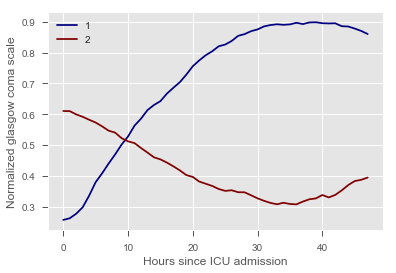

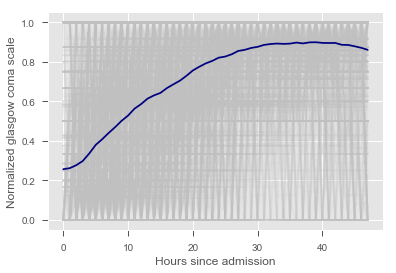

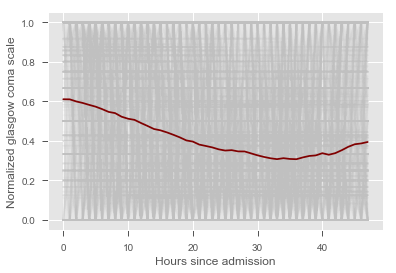

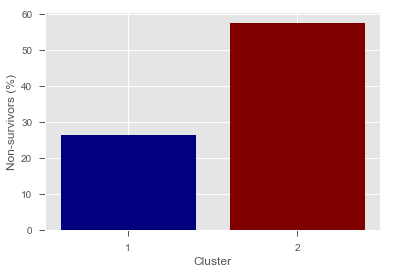

Using 2133 ICU stays for creating the clusters
3 clusters
Cluster 1: 851 observations
Cluster 2: 678 observations
Cluster 3: 604 observations


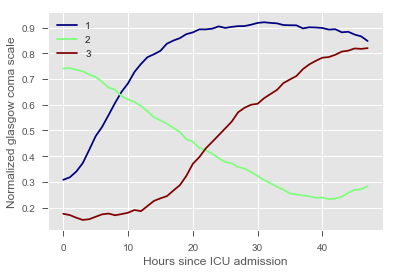

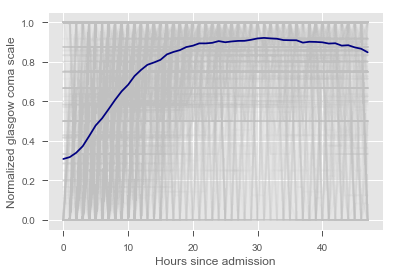

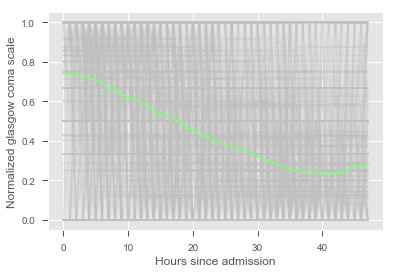

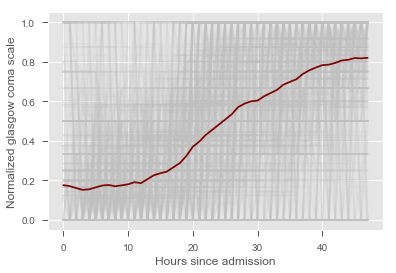

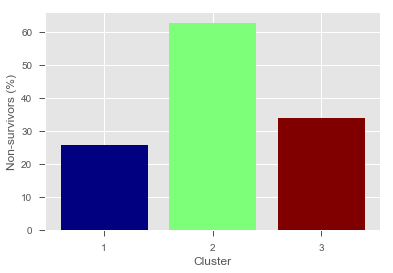

Using 2133 ICU stays for creating the clusters
4 clusters
Cluster 1: 506 observations
Cluster 2: 420 observations
Cluster 3: 660 observations
Cluster 4: 547 observations


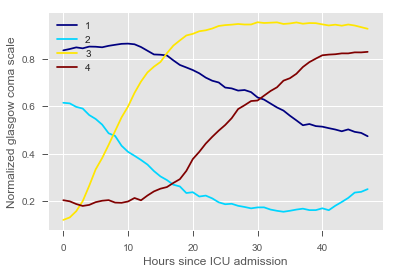

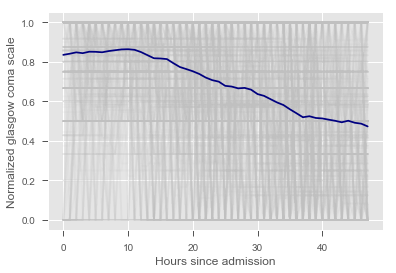

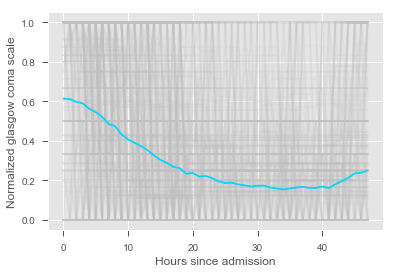

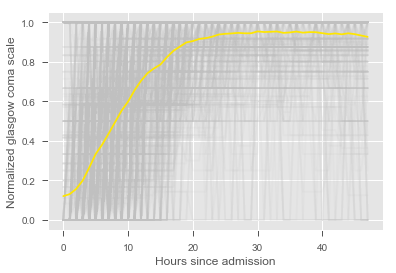

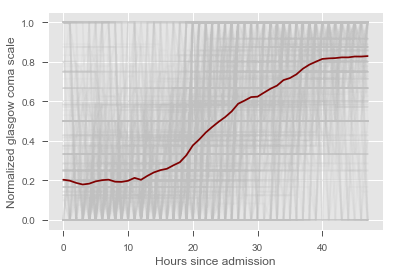

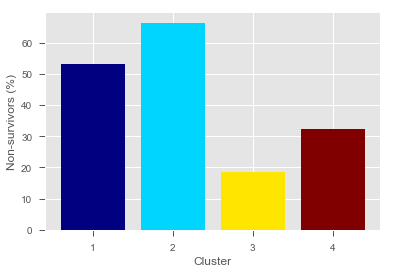

Using 2133 ICU stays for creating the clusters
5 clusters
Cluster 1: 543 observations
Cluster 2: 356 observations
Cluster 3: 538 observations
Cluster 4: 352 observations
Cluster 5: 344 observations


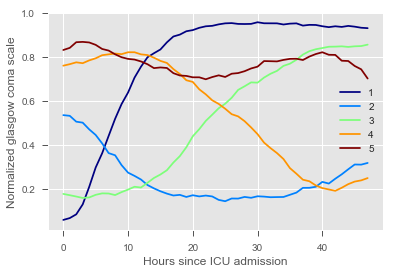

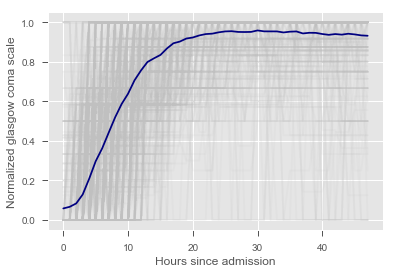

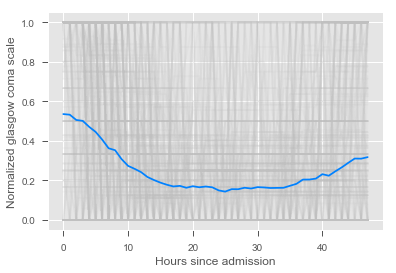

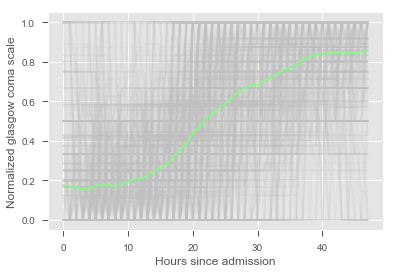

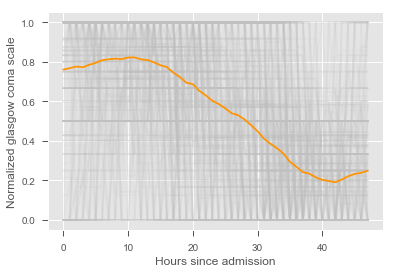

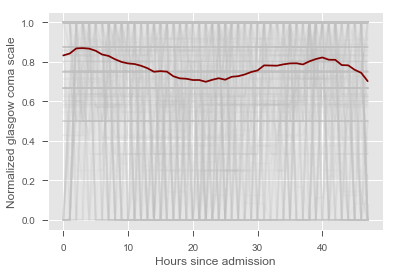

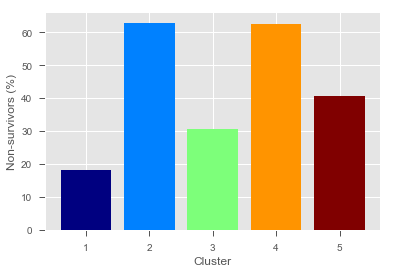

Using 2133 ICU stays for creating the clusters
6 clusters
Cluster 1: 285 observations
Cluster 2: 436 observations
Cluster 3: 260 observations
Cluster 4: 492 observations
Cluster 5: 328 observations
Cluster 6: 332 observations


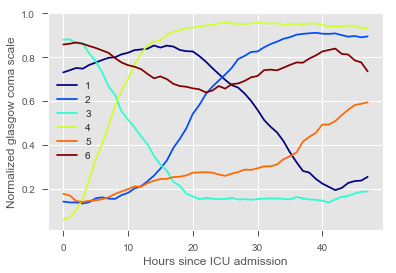

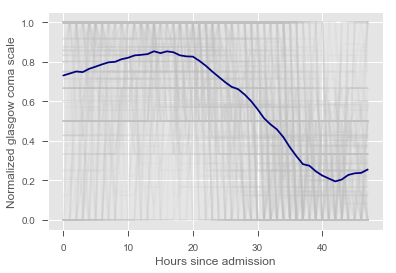

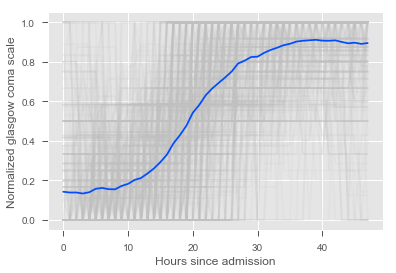

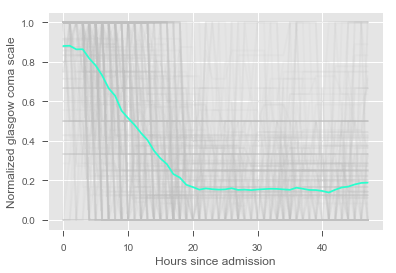

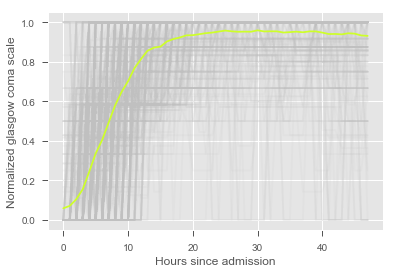

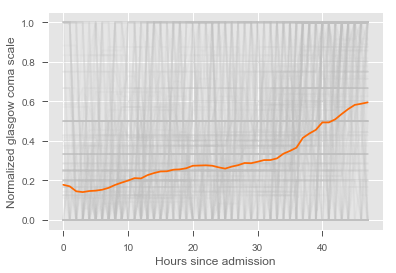

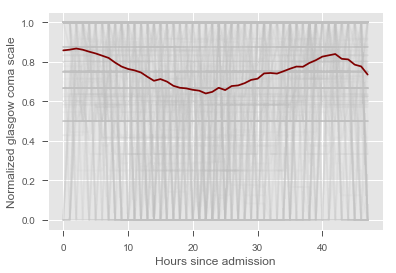

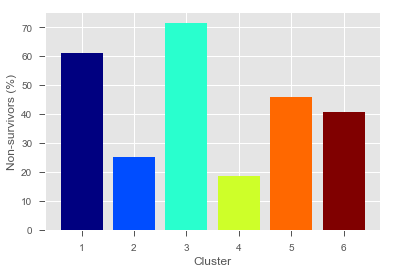

In [22]:
variable = 'glasgow coma scale'
K_max = 7
# ids_clustering = data_transf_inv.index.unique()
ids_clustering = X_train.index.unique()

for K in range(2, K_max):
    data4clustering, cluster_labels = clustering(variable, ids_clustering, K)

In the example, clustering is performed for glasgow coma scale (GCS), for a varying number of clusters. 

The idea is to assess the quality of the clusters in a qualitative way, rather than resorting to quantitative methods typically known as cluster validity indices. 

* $K = 2$
    * shows two very distinct patterns, similar to what we found by partitioning by mortality
    * but, we want some more stratification
* $K = 3$
    * 2 groups where GCS is improving with time (clusters 2 and 3)
    * 1 group where GCS is deteriorating.
    * yes, this is reflected in terms of our ground truth labels, even though we did not provide that information to the clustering. Mortality$>60\%$ in cluster 1 vs $25\%$ and $32\%$ in clusters 2 and 3.
* $K = 4$
    * one more "bad" cluster appears
* $K = 5$
    * clusters 1 and 2 have similar patterns and similar mortality distribution
    * cluster 3 is our "worst" cluster. Mortality is close to $70\%$.

In summary, every $K$ that we studied gives us an interesting view of the evolution of GCS and its relation with mortality. For the sake of simplicity, this analysis is only shown for GCS. The choice of the number of clusters for the remaining variables has been made likewise.

Next we are going to perform clustering for each variable, and predict cluster labels for new data. Cluster labels will be used to add another layer of information to our machine learning models.

### 7.3.2. Training and testing

* Training phase: perform clustering using the traininig data.

* Test phase: assign new observations to one of the clusters defined in the training phase. Each observation is assigned to the most similar cluster, i.e., to the cluster whose center is at a smaller distance.

diastolic BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 652 observations
Cluster 2: 589 observations
Cluster 3: 446 observations
Cluster 4: 665 observations


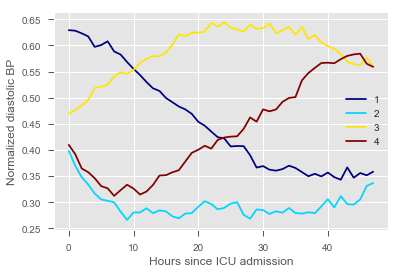

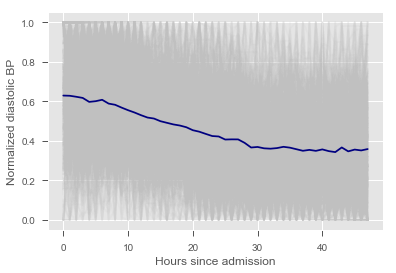

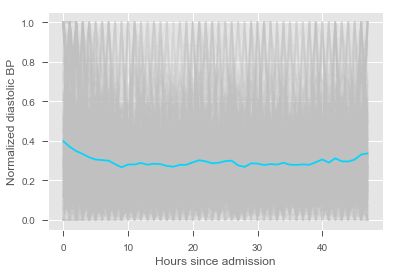

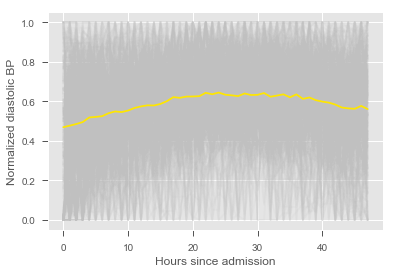

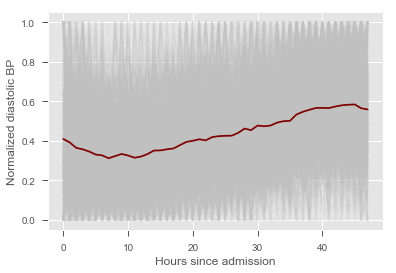

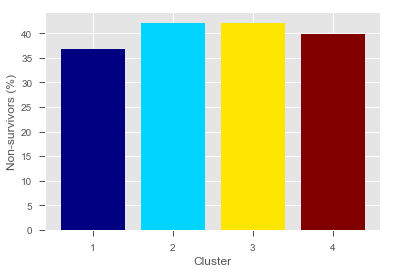

glasgow coma scale
Using 2133 ICU stays for creating the clusters
Using 1251 ICU stays for cluster assignment
4 clusters
Cluster 1: 506 observations
Cluster 2: 420 observations
Cluster 3: 660 observations
Cluster 4: 547 observations


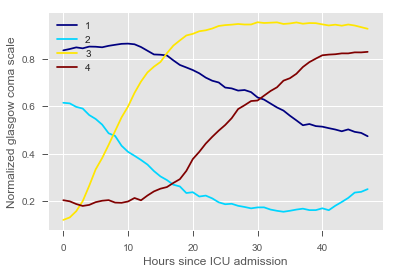

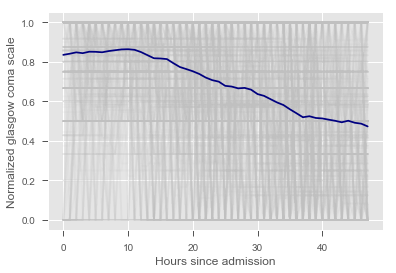

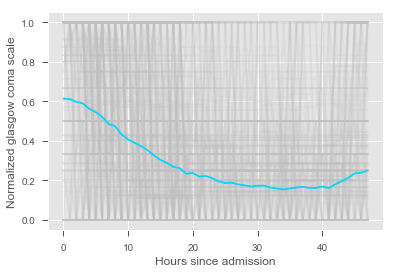

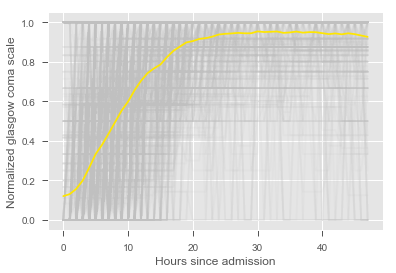

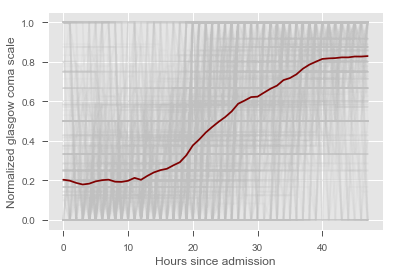

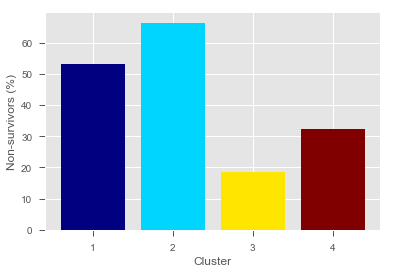

glucose
Using 2351 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 483 observations
Cluster 2: 775 observations
Cluster 3: 532 observations
Cluster 4: 561 observations


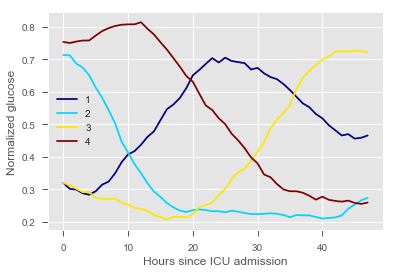

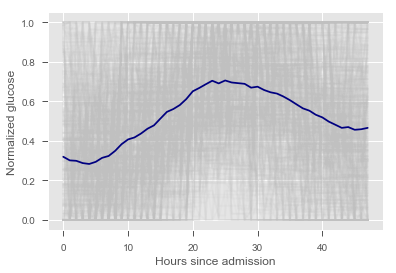

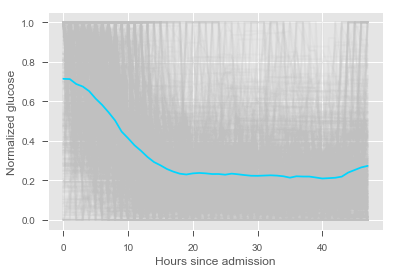

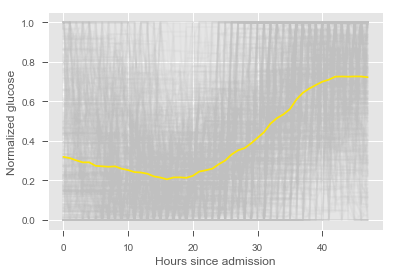

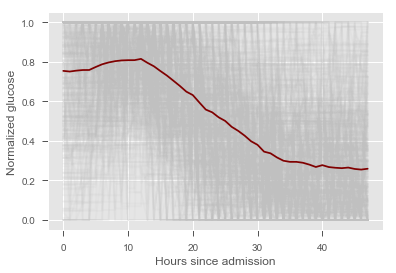

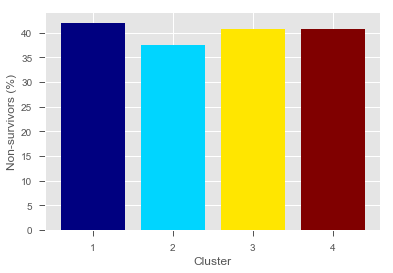

heart rate
Using 2349 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 428 observations
Cluster 2: 419 observations
Cluster 3: 524 observations
Cluster 4: 487 observations
Cluster 5: 491 observations


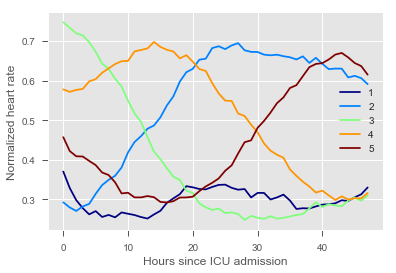

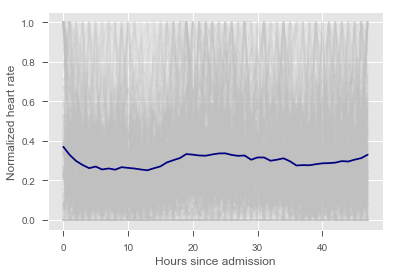

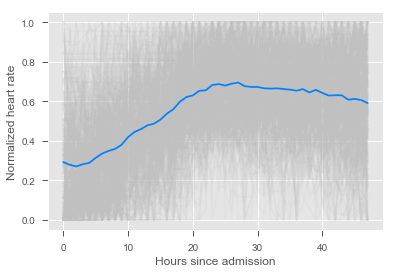

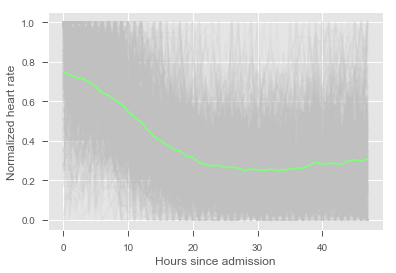

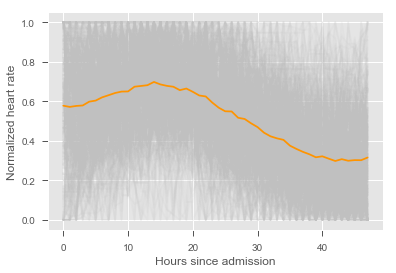

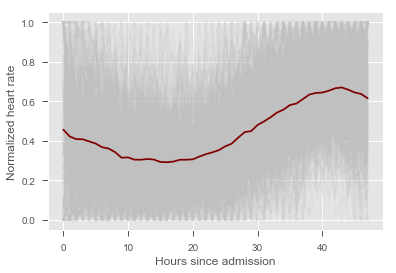

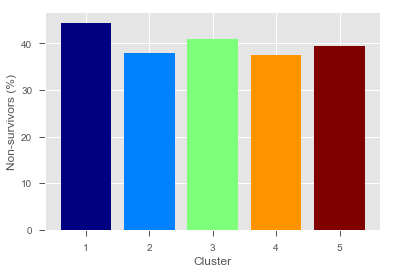

mean BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 403 observations
Cluster 2: 434 observations
Cluster 3: 558 observations
Cluster 4: 511 observations
Cluster 5: 446 observations


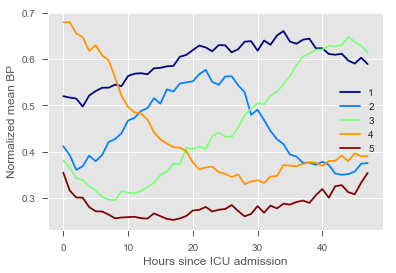

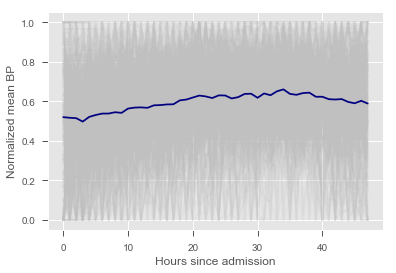

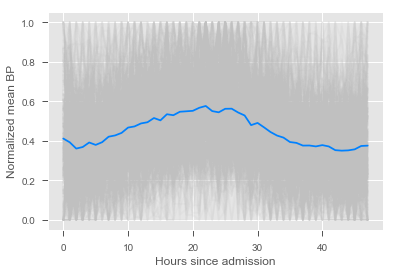

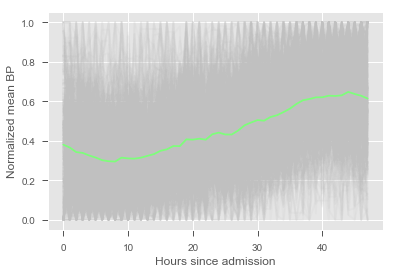

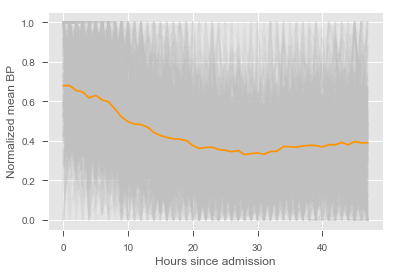

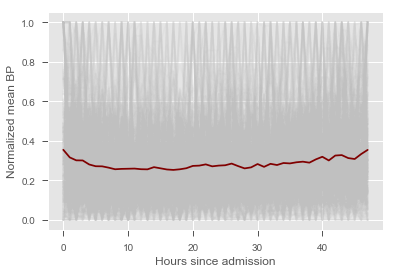

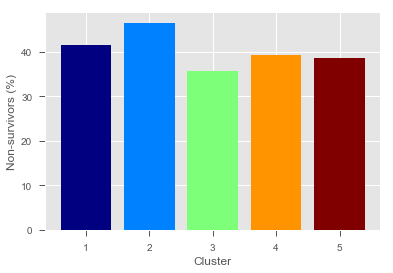

oxygen saturation
Using 2341 ICU stays for creating the clusters
Using 1378 ICU stays for cluster assignment
3 clusters
Cluster 1: 1207 observations
Cluster 2: 654 observations
Cluster 3: 480 observations


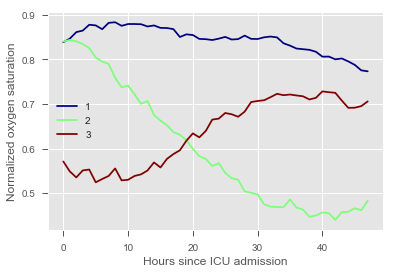

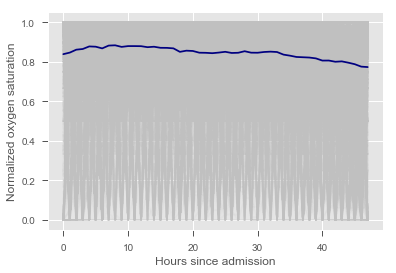

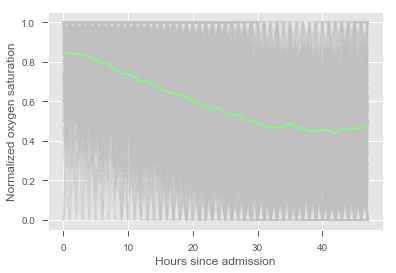

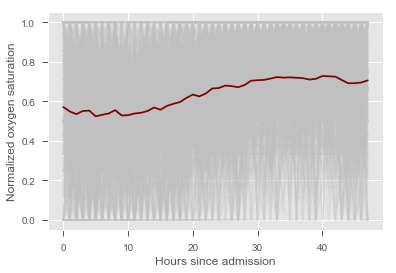

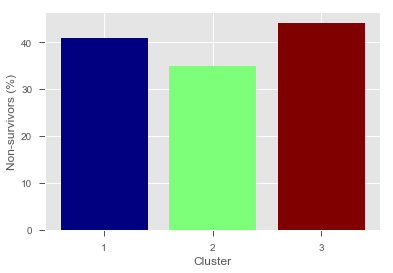

respiratory rate
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 572 observations
Cluster 2: 739 observations
Cluster 3: 558 observations
Cluster 4: 483 observations


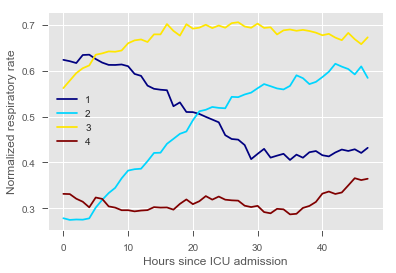

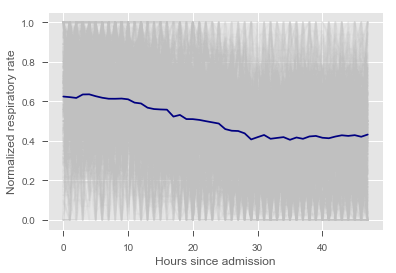

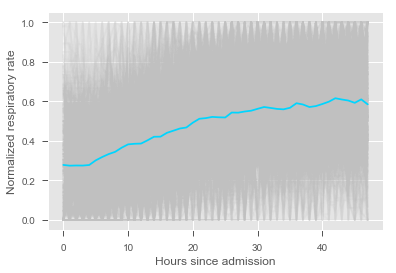

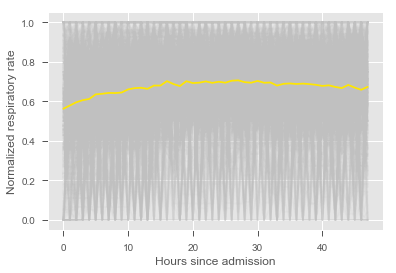

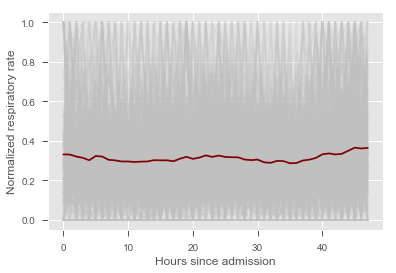

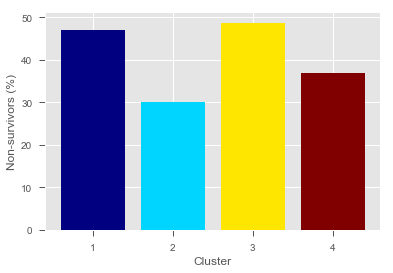

systolic BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 572 observations
Cluster 2: 426 observations
Cluster 3: 453 observations
Cluster 4: 439 observations
Cluster 5: 462 observations


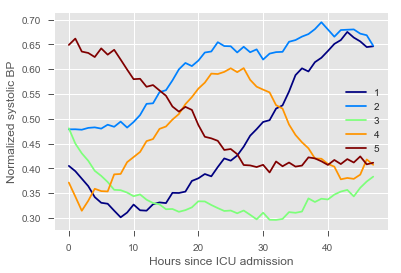

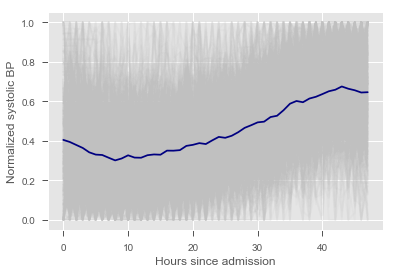

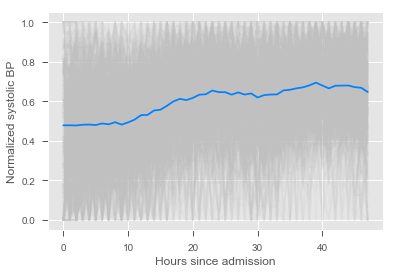

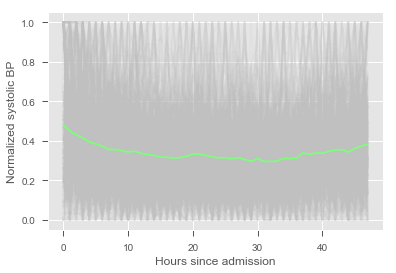

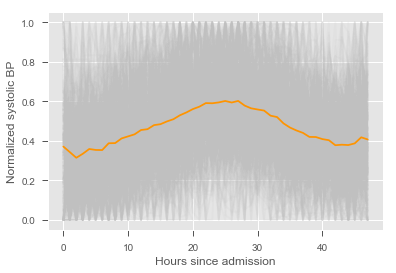

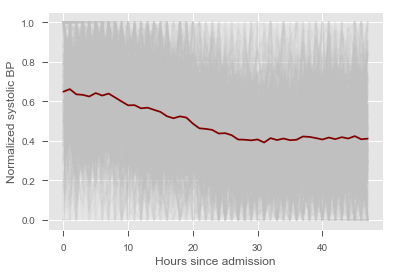

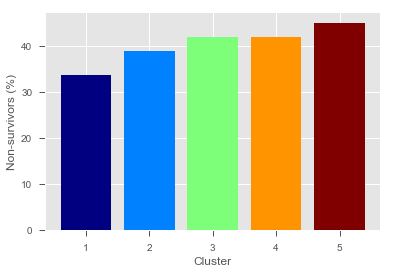

temperature
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
2 clusters
Cluster 1: 1308 observations
Cluster 2: 1044 observations


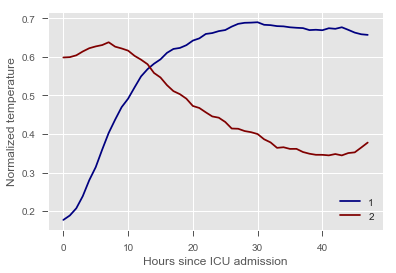

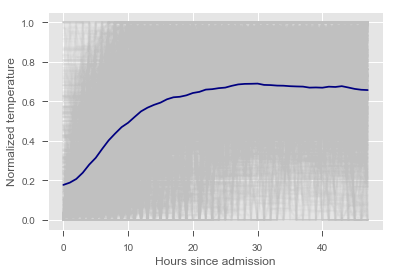

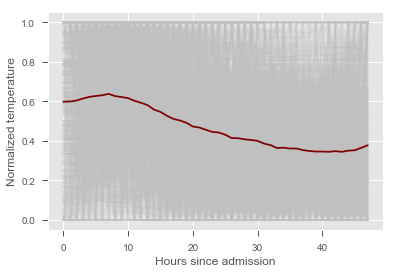

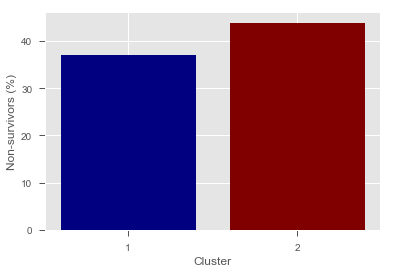

pH
Using 2314 ICU stays for creating the clusters
Using 1363 ICU stays for cluster assignment
4 clusters
Cluster 1: 485 observations
Cluster 2: 586 observations
Cluster 3: 830 observations
Cluster 4: 413 observations


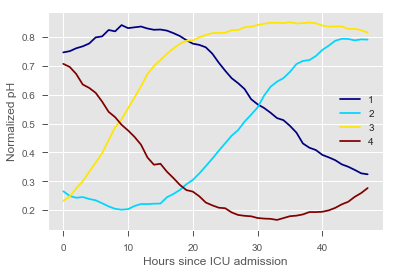

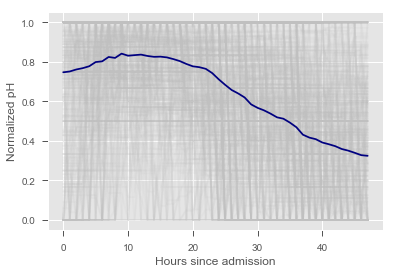

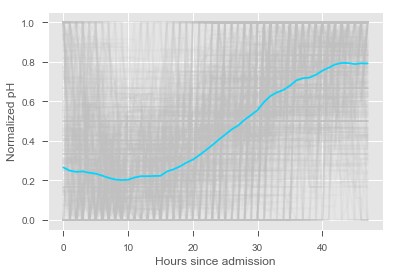

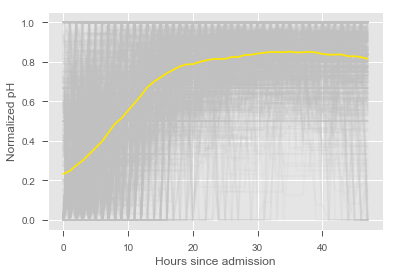

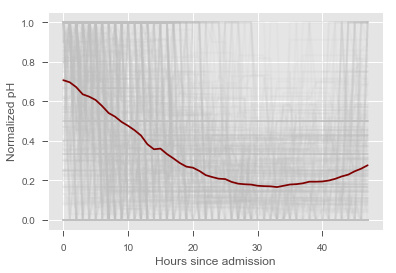

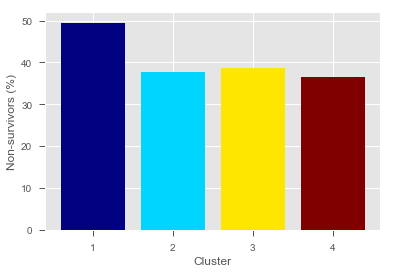

In [23]:
Ks = dict([('diastolic BP', 4), 
           ('glasgow coma scale', 4),
           ('glucose', 4),
           ('heart rate', 5),
           ('mean BP', 5),
           ('oxygen saturation', 3),
           ('respiratory rate', 4),
           ('systolic BP', 5),
           ('temperature', 2),
           ('pH', 4),
          ])

id_train = X_train.index.unique()
id_test = X_test.index.unique()
cluster_labels_train = pd.DataFrame()
cluster_labels_test = pd.DataFrame()
for feature in variables:
    print(feature)
    K = Ks[feature]
    data4clustering, labels_train, labels_test = clustering(feature, id_train, K, id_test)

    labels_test.columns=['CL ' + feature]
    labels_train.columns=['CL ' + feature]
    
    cluster_labels_train = pd.concat([cluster_labels_train, labels_train], axis=1).dropna(axis=0)
    cluster_labels_test = pd.concat([cluster_labels_test, labels_test], axis=1).dropna(axis=0)

for col in cluster_labels_train:
    cluster_labels_train[col] = cluster_labels_train[col].astype('category')

for col in cluster_labels_test:
    cluster_labels_test[col] = cluster_labels_test[col].astype('category')

Now that we have the clusters we can start creating the models. We will try with and without clustering information.

## 7.4. Normalize the data

Normalize the extracted features before concatenating cluster labels. 

Note that:

* The data is normalized for the entire dataset at once, and not for each patient individually.

* Normalization is useful when solving for example least squares or functions involving the calculation of distances. Normalization does not impact the performance of a decision tree. 

In [24]:
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

## 7.5. Concatenate predicted clustering labels with input data

In [25]:
# drop_first : bool, default False
# Whether to get k-1 dummies out of k categorical levels by removing the first level.
# binary indicator representation = dummy

cluster_labels_train_dummy = pd.get_dummies(cluster_labels_train, prefix_sep='_', drop_first=True)
X_train_clust = pd.concat([X_train, cluster_labels_train_dummy], axis=1).dropna(axis=0)
y_train_clust = y_train.loc[X_train.index].copy()

cluster_labels_test_dummy = pd.get_dummies(cluster_labels_test, prefix_sep='_', drop_first=True)
X_test_clust = pd.concat([X_test, cluster_labels_test_dummy], axis=1).dropna(axis=0)
y_test_clust = y_test.loc[X_test.index].copy()

print('Number of observations in training set: ' + str(X_train_clust.shape[0]))
print('Number of observations in test set: ' + str(X_test_clust.shape[0]))
display.display(X_train_clust.head())

Number of observations in training set: 2091
Number of observations in test set: 1232


min diastolic BP  min glasgow coma scale  min glucose  \
icustay                                                           
200003.0          0.573171                0.166667     0.347458   
200019.0          0.365854                0.250000     0.461864   
200045.0          0.195122                0.000000     0.042373   
200059.0          0.634146                0.583333     0.478814   
200322.0          0.658537                0.166667     0.411017   

          min heart rate  min mean BP  min oxygen saturation  \
icustay                                                        
200003.0        0.532258     0.523810                  0.915   
200019.0        0.338710     0.612698                  0.950   
200045.0        0.516129     0.469841                  0.900   
200059.0        0.520161     0.619048                  0.930   
200322.0        0.443548     0.695238                  0.920   

          min respiratory rate  min systolic BP  min temperature    min pH  \
icustay                                                                      
200003.0              0.000000         0.535948         0.761590  0.736111   
200019.0              0.366667         0.843137         0.735102  0.736111   
200045.0              0.066667         0.679739         0.728476  0.500000   
200059.0              0.350000         0.581699         0.364243  0.750000   
200322.0              0.200000         0.849673         0.761590  0.236111   

            ...      CL respiratory rate_2.0  CL respiratory rate_3.0  \
icustay     ...                                                         
200003.0    ...                          0.0                      0.0   
200019.0    ...                          0.0                      0.0   
200045.0    ...                          1.0                      0.0   
200059.0    ...                          0.0                      0.0   
200322.0    ...                          0.0                      0.0   

          CL systolic BP_1.0  CL systolic BP_2.0  CL systolic BP_3.0  \
icustay                                                                
200003.0                 1.0                 0.0                 0.0   
200019.0                 0.0                 0.0                 0.0   
200045.0                 0.0                 1.0                 0.0   
200059.0                 0.0                 0.0                 1.0   
200322.0                 0.0                 0.0                 1.0   

          CL systolic BP_4.0  CL temperature_1.0  CL pH_1.0  CL pH_2.0  \
icustay                                                                  
200003.0                 0.0                 1.0        0.0        1.0   
200019.0                 1.0                 1.0        0.0        0.0   
200045.0                 0.0                 0.0        0.0        1.0   
200059.0                 0.0                 0.0        0.0        0.0   
200322.0                 0.0                 1.0        0.0        0.0   

          CL pH_3.0  
icustay              
200003.0        0.0  
200019.0        1.0  
200045.0        0.0  
200059.0        1.0  
200322.0        0.0  

[5 rows x 71 columns]

# 8. Modeling

8.1. Definition of performance measures

8.2. k-Nearest neighbors

8.3. Logistic regression

8.4. Decision tree

8.5. Random Forest

## 8.1. Definition of performance measures

* Threshold, AUC, sensitivity and specificity

Accuracy can be misleading when classes are imbalanced

In [26]:
def performance(y, y_pred, print_, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a predifined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds. """
    frames = []
    for x in range(101, -2, -1):
        threshold = x/100
        y_pred_class = y_pred.copy()
        y_pred_class[y_pred_class >= threshold] = 1
        y_pred_class[y_pred_class < threshold] = 0

        compare_class = np.concatenate([y, y_pred_class], axis=1)

        tp = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 1)))
        tn = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 0)))
        fp = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 1)))
        fn = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 0)))
  
        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        FPR = 1 - specificity
        difference = np.abs(sensitivity-specificity)
        frames.append((threshold, tp, tn, fp, fn, sensitivity, specificity, FPR, difference))

    performance_thr = pd.DataFrame(frames, columns=('threshold', 'tp', 'tn', 'fp', 'fn', 'sensitivity', 'specificity', 'FPR', 'difference'))

    if args:
        threshold = args[0]
        # print('TEST SET')
    else:
        id_min = performance_thr.loc[performance_thr['difference'].idxmin()]
        threshold = id_min.loc['threshold']
        # print('TRAINING SET')
        
    y_pred_class = y_pred.copy()
    y_pred_class[y_pred_class >= threshold] = 1
    y_pred_class[y_pred_class < threshold] = 0
    compare_class = np.concatenate([y, y_pred_class], axis=1)

    tp = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 1)))
    tn = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 0)))
    fp = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 1)))
    fn = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 0)))

    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
           
    # Alternatively, use:
    # from scipy.integrate import quad
    # AUC = np.trapz(performance_thr['sensitivity'], x = performance_thr['FPR'])
    # print('AUC: ' + str(AUC))
    AUC = 0
    for row, performance in performance_thr.iloc[:-1].iterrows():
        row = row + 1
        AUC = AUC + ((performance_thr.loc[row]['FPR']) - (performance_thr.loc[row - 1]['FPR'])) * performance_thr.loc[row]['sensitivity']

    if print_ == 1:
        print('Threshold: ' + str(threshold))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        print("Accuracy: " + str( round((tp + tn) / (tp + tn + fp + fn), 2 )))
        print('Sensitivity: ' + str(round(sensitivity,2)))
        print('Specificity: ' + str(round(specificity,2)))                
        print('AUC: ' + str(round(AUC,2)))
    
        plt.figure()
        plt.scatter(x = performance_thr['FPR'], y = performance_thr['sensitivity'])
        plt.plot(performance_thr['FPR'], performance_thr['sensitivity'])
        plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        plt.show()
        

    return threshold, AUC, sensitivity, specificity


## 8.2. k-Nearest neighbors (kNN)

/Users/catiasalgado/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


AUC: 0.64
Threshold: 1.0
TP: 91
TN: 1043
FP: 98
FN: 155
Accuracy: 0.82
Sensitivity: 0.37
Specificity: 0.91
AUC: 0.95


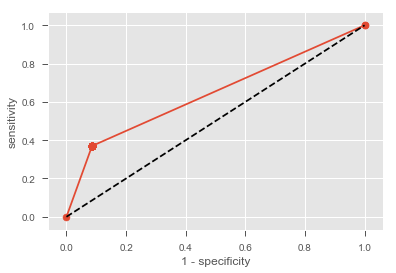

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# instantiate learning model
knn = KNeighborsClassifier(n_neighbors=6)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred).set_index(y_test.index)

print_ = 1
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ' + str(round(metrics.auc(fpr, tpr), 2)))
_, _, _, _ = performance(y_test, y_pred, print_)

## 8.3. Logistic regression

When starting a machine learning project it is always a good approach to start with a very simple model. The simple model will give a sense of how challenging the question is.

Note that, one of the assumptions of LR is that the independent variables should be independent of each other to avoid multicollinearity. We are ignoring that assumption by using features highly correlated.

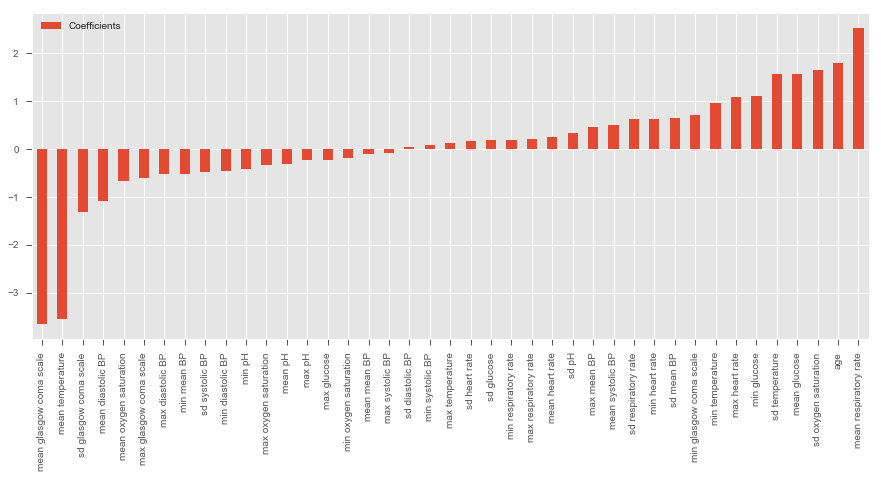

Threshold: 0.4
TP: 712
TN: 1061
FP: 350
FN: 229
Accuracy: 0.75
Sensitivity: 0.76
Specificity: 0.75
AUC: 0.84


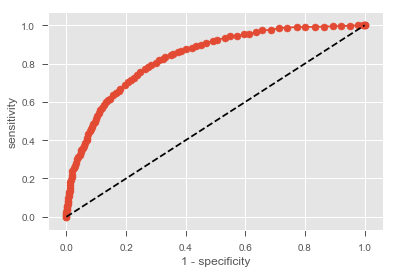

Threshold: 0.4
TP: 180
TN: 870
FP: 271
FN: 66
Accuracy: 0.76
Sensitivity: 0.73
Specificity: 0.76
AUC: 0.83


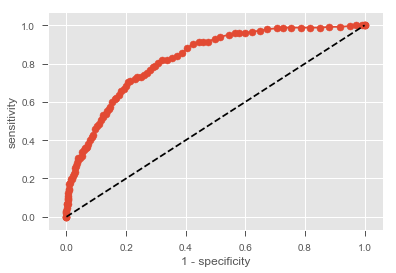

In [28]:
# import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

print_ = 1

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

# plot model coefficients
coef = pd.DataFrame(np.transpose(logreg.coef_), index = X_train.columns, columns = ['Coefficients'])
coef = coef.sort_values(by=['Coefficients'])
coef.plot(kind = 'bar', figsize=(15, 6))
plt.show()
# display.display(coef)

# tune - parameter estimation 
y_pred_prob_train = logreg.predict_proba(X_train)
threshold, _, _, _ = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

# test
y_pred_prob_test = logreg.predict_proba(X_test)
y_pred_class_test = logreg.predict(X_test)

#fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob_train[1], pos_label=1)
#print(metrics.auc(fpr, tpr))

_, _, _, _ = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)



### 8.3.1. Feature selection

#### a) Sequential forward selection / forward stepwise selection

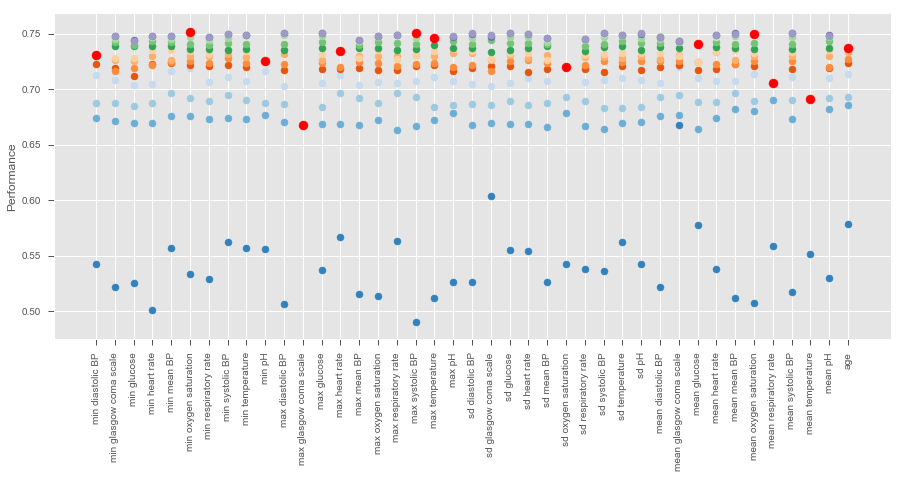

Number of features selected: 13

Selected features by order of selection: ['max glasgow coma scale', 'mean temperature', 'mean respiratory rate', 'sd oxygen saturation', 'min pH', 'min diastolic BP', 'max heart rate', 'age', 'mean glucose', 'max temperature', 'mean oxygen saturation', 'max systolic BP', 'min oxygen saturation']


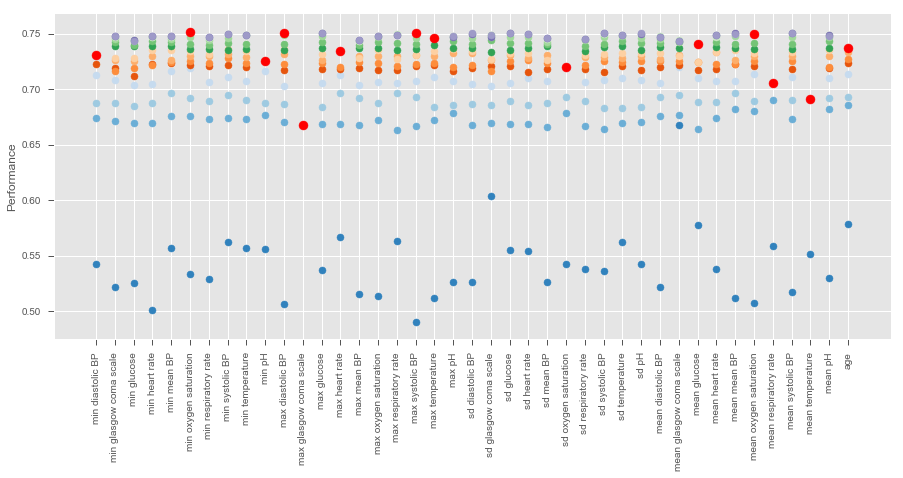

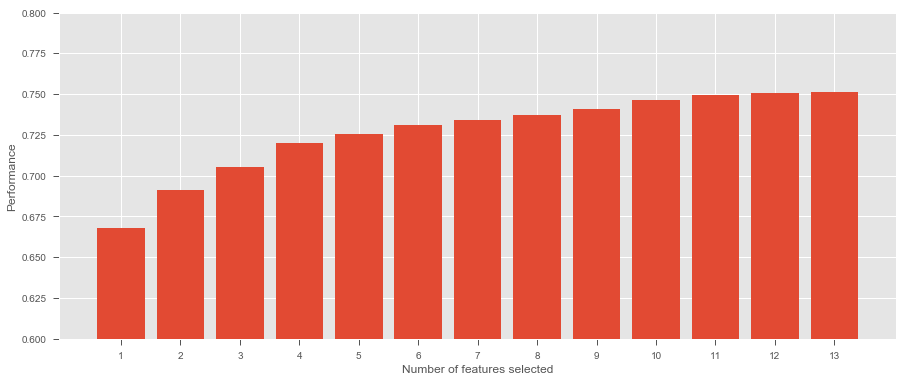

In [29]:
test_size = 0.3
print_part = 1
use_test_set = 0

if use_test_set == 1:
    # divide the training set in training/test in order to select features
    X_train_SFS, X_test_SFS, y_train_SFS, y_test_SFS = data_partioning(pd.concat([X_train, y_train], axis = 1), [], test_size, print_part)
else:
    X_train_SFS = X_train.copy()
    X_test_SFS = X_test.copy()
    y_train_SFS = y_train.copy()
    y_test_SFS = y_test.copy()

to_test_features = X_train.columns
selected_features = []
test_set = []
results_selected = []
print_ = 0
previous_perf = 0
gain = 1
it = 0

colormap1= plt.get_cmap('tab20c')
colors = iter(colormap1(np.linspace(0,1,20)))

pl.figure(num=None, figsize=(15, 6))
pl.xticks(rotation='vertical')
pl.ylabel('Performance')

while gain > 0:
    frames = []
    it += 1
    print('Iteration ' + str(it))
    color = next(colors)
    for col in to_test_features:
        if selected_features:
            test_set = selected_features.copy()
            test_set.append(col)
        else:
            test_set = [col]  
        
        model = LogisticRegression()
        model.fit(X_train_SFS[test_set], y_train_SFS.values.ravel())
                
        if use_test_set == 1:
            y_pred_prob_train = model.predict_proba(X_train_SFS[test_set]) 
            threshold, _, _, _ = performance(y_train_SFS, np.delete(y_pred_prob_train, 0, 1), print_)
            y_pred_prob = model.predict_proba(X_test_SFS[test_set])
            _, AUC, sens, spec = performance(y_test_SFS, np.delete(y_pred_prob, 0, 1), print_, threshold)
        
        else: 
            # Use this if you want to use a test set for feature selection
            y_pred_prob_train = model.predict_proba(X_train_SFS[test_set]) 
            threshold, AUC, sens, spec = performance(y_train_SFS, np.delete(y_pred_prob_train, 0, 1), print_)
                
        frames.append([test_set, (sens+spec)/2, sens, spec])
        
        pl.scatter(x = col, y = (sens+spec)/2, c = color)       
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(1.0)
        # plt.xticks(range(len(features)),pd_list_feat['Feature'], rotation='vertical')
        
    results = pd.DataFrame(frames, columns=('Feature', 'Performance', 'Sensitivity', 'Specificity'))
    id_max = results.loc[results['Performance'].idxmax()]
    gain = id_max['Performance'] - previous_perf
    
    pl.scatter(x = id_max['Feature'][-1], y = id_max['Performance'], c = 'red', s = 80)
    
    if gain > 0:
        previous_perf = id_max['Performance']
        to_test_features = to_test_features.drop(id_max['Feature'][-1])
        selected_features.append(id_max['Feature'][-1])
        results_selected.append(id_max)
    # print('Gain in performance: ' + str(gain))
    # else dont had the last to the feature set, will exit the loop

#selected_features = selected_features[:-1]
#results_selected = results_selected[:-1]
results_selected = pd.DataFrame(results_selected)
# the last one added no value, discard it 
print('Number of features selected: ' + str(len(selected_features)))
print('')
print('Selected features by order of selection: ' + str(selected_features))
plt.figure(num=None, figsize=(15, 6))
plt.bar(range(1,it,1),results_selected['Performance'])
plt.xlabel('Number of features selected')
plt.ylabel('Performance')
plt.ylim(0.6,0.8)
plt.xticks(range(1,it,1))
plt.show()

selected_features_sfs = set(selected_features)

#### b) Recursive Feature Elimination (RFE) 
Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Define:

* **n_features_to_select**: number of features to select. If None, half of the features are selected.
Default=None

In [30]:
from sklearn.feature_selection import RFE

# n_features_to_select = np.floor(len(X_train.columns)/2)
n_features_to_select = 15

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select)
rfe = rfe.fit(X_train, y_train.values.ravel())

selected_features_rfe = set(X_train.columns[rfe.support_])

print('Number of features selected: ' + str(len(X_train.columns[rfe.support_])))
print()
print('Selected features:')
display.display( selected_features_rfe)
print()
#print(rfe.ranking_)


Number of features selected: 15

Selected features:


{'age',
 'max heart rate',
 'mean diastolic BP',
 'mean glasgow coma scale',
 'mean glucose',
 'mean oxygen saturation',
 'mean respiratory rate',
 'mean temperature',
 'min glucose',
 'min pH',
 'min temperature',
 'sd glasgow coma scale',
 'sd mean BP',
 'sd oxygen saturation',
 'sd temperature'}

#### c) Features in common

In [31]:
selected_features_sfs_rfe = list(selected_features_rfe & selected_features_sfs)
print('Number of features in common: ' + str(len(selected_features_sfs_rfe)))
display.display(selected_features_sfs_rfe)

Number of features in common: 8


['age',
 'mean respiratory rate',
 'mean oxygen saturation',
 'mean glucose',
 'min pH',
 'mean temperature',
 'sd oxygen saturation',
 'max heart rate']

### 8.3.2. Modeling with selected features
A LR model is trained and test using:
- the same data used for training. This allows investigating potential overfitting. If the AUC is 1 it is very likely that the model is overfitting the training data. It also allows parameter estimation 
- an independent test set not used before

Threshold: 0.39
TP: 621
TN: 901
FP: 510
FN: 320
Accuracy: 0.65
Sensitivity: 0.66
Specificity: 0.64
AUC: 0.7


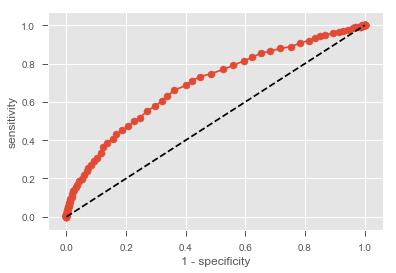

Threshold: 0.39
TP: 154
TN: 749
FP: 392
FN: 92
Accuracy: 0.65
Sensitivity: 0.63
Specificity: 0.66
AUC: 0.69


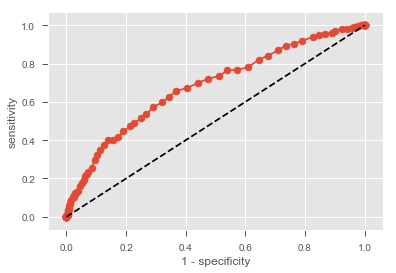

In [32]:
print_ = 1
logreg = LogisticRegression()
logreg.fit(X_train[selected_features_sfs_rfe], y_train.values.ravel())

# tune - parameter estimation 
y_pred_prob_train = logreg.predict_proba(X_train[selected_features_sfs_rfe])
threshold, _, _, _ = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

# test
y_pred_prob_test = logreg.predict_proba(X_test[selected_features_sfs_rfe])
y_pred_class_test = logreg.predict(X_test[selected_features_sfs_rfe])

#fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob_train[1], pos_label=1)
#print(metrics.auc(fpr, tpr))

_, _, _, _ = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)

## 8.4. Decision tree

### 8.4.1. CART algorithm 
https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/

* selecting input variables 
* selecting split points on those variables until a suitable tree is constructed

The selection of variables and the specific split is chosen using a greedy algorithm to minimize a cost function. Tree construction ends using a predefined stopping criterion, such as a minimum number of training instances assigned to each leaf node of the tree.

#### a) Greedy Splitting

* recursive binary splitting, a process of dividing up the input space

All input variables and all possible split points are evaluated and chosen in a greedy manner (the very best split point is chosen each time).

All values are lined up and different split points are tried and tested using a cost function. The split with the lowest cost is selected. 

For classification, the **Gini index** (G) function (also known as Gini impurity) is used which provides an indication of how "pure" the leaf nodes are. It gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. 

* **perfect class purity**: a node that has all classes of the same ($G=0$)
* **worst class purity**: a node that has a 50-50 split of classes ($G=0.5$)

The $G$ for each node is weighted by the total number of instances in the parent node. For a chosen split point in a binary classification problem, $G$ is calculated as:

$G = ((1 -g1_1^2 + g1_2^2) \times \frac{ng1}{n})+ ((1 - g2_1^2 + g2_2^2) \times \frac{ng2}{n})$

* $g1_1$: proportion of instances in group 1 for class 1
* $g1_2$: proportion of instances in group 1 for class 2
* $g2_1$: proportion of instances in group 2 for class 1
* $g2_2$: proportion of instances in group 2 for class 2
* $ng1$: total number of instances in group 1
* $ng2$: total number of instances in group 2 
* $n$: total number of instances we are trying to group from the parent node

#### b) Stopping Criterion

The most common stopping procedure is to use a minimum count on the number of training observations assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

The minimum count of training observations is tuned to the dataset. It defines how specific to the training data the tree will be. Too specific (e.g. a count of 1) and the tree will overfit the training data and likely have poor performance on the test set.

**DecisionTreeClassifier** from sklearn.ensemble

Some parameters we can define:

* **criterion**: function to measure the quality of a split.
Default="gini"

* **splitter**: strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
Default="best"

* **max_features**: maximum number of features in each tree.
Default is sqrt(n_features)

* **max_depth**: maximum depth of the tree.
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.
Default=2

* **min_samples_leaf**: minimum number of samples required to be at a leaf node. 
Default=1

* **max_leaf_nodes**: grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
default=None

* **random_state**: if int, seed used by the random number generator.
Default=None


Investigate how the bias and variance are affected by different choices of parameters. Remember:

* **Bias**: How the algorithm performs on the training set.
* **Variance**: how much worse the algorithm does on the test set than the training set.

Threshold: 0.54
TP: 733
TN: 1087
FP: 324
FN: 208
Accuracy: 0.77
Sensitivity: 0.78
Specificity: 0.77
AUC: 0.88


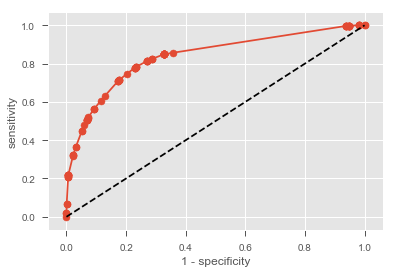

Threshold: 0.54
TP: 171
TN: 820
FP: 321
FN: 75
Accuracy: 0.71
Sensitivity: 0.7
Specificity: 0.72
AUC: 0.81


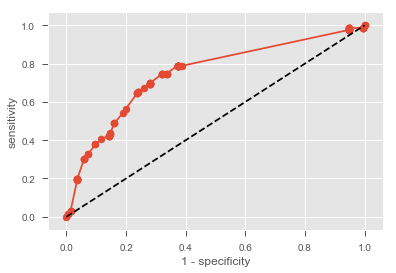

In [33]:
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

print_ = 1
clf_gini = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, random_state=2, splitter='best')

# class_weight='balanced' - check this

clf_gini.fit(X_train, y_train)

# tune - parameter estimation 
y_pred_prob_train = clf_gini.predict_proba(X_train)
threshold, _, _, _ = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

# test
y_pred_class_test = clf_gini.predict(X_test)
y_pred_prob_test = clf_gini.predict_proba(X_test)
# The predicted class probability which is the fraction of samples of the same class in a leaf.

_, _, _, _ = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
# metrics.auc(fpr, tpr)

### 8.4.2. Tree visualization

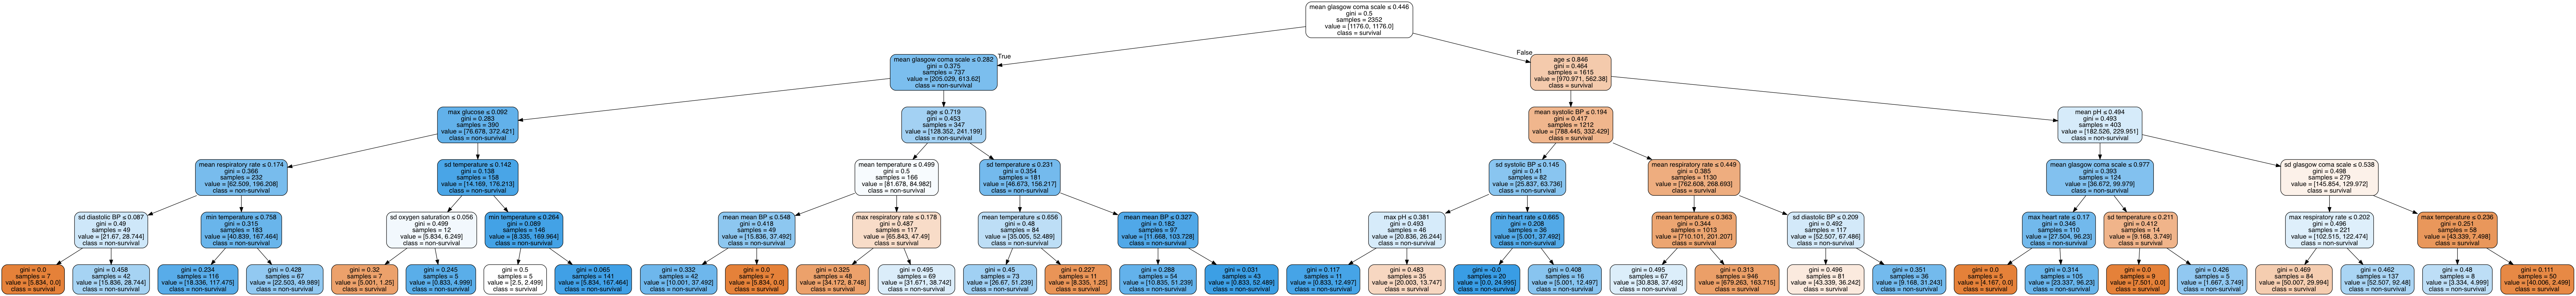

In [34]:
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_gini, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=["survival", "non-survival"],
                feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
        

## 8.5. Random forest

Random forest comprises split-variable selection and sub-sampling.

> "The essential idea in bagging is to average many noisy but approximately unbiased models, and hence reduce the variance. Trees are ideal candidates for bagging, since they can capture complex interaction structures in the data, and if grown sufficiently deep, have relatively low bias. Since trees are notoriously noisy, they benefit greatly from the averaging". Friedman et al. - 2008 - The Elements of Statistical Learning.
 
**Algorithm**. Random Forest for classification (training)

$B:$ Number of trees

1. For $b=1$ to $B$

    1.1. Draw a bootstrap sample of size $N_b$ from the training data

    1.2. Grow a random tree $T_b$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of the tree, until the minimum node size $n_{min}$ is reached. See **CART** algorithm.
        
        1.2.1. Select $m$ variables at random from the $p$ variables
        1.2.2. Pick the best variable/split-point among $m$
        1.2.3. Split the node into two daughter nodes

2. Output the ensemble of trees

**Algorithm**. Random Forest for classification (testing)

Let $C_b(x_i)$ be the class prediction of the $b$th tree in the ensemble for observation $x_i$. 

Then, the class prediction of random forest for observation $x_i$ is: 

$C_{rf}^B(x_i)=\text{majority vote}\left \{  C_b(x_i) \right \}_1^B$



**RandomForestClassifier** from sklearn.ensemble

Parameters to define:

* **n_estimators**: number of trees in the forest.

* **criterion**: function to measure the quality of a split.
Default="gini"

* **max_features**: maximum number of features in each tree.
Default is sqrt(n_features)

* **max_depth**: maximum depth of the tree.
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.
default=2

* **min_samples_leaf**: minimum number of samples required to be at a leaf node. 
Default=1

* **random_state**: if int, seed used by the random number generator.
Default=None

* **bootstrap**: Whether bootstrap samples are used when building trees. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True.
Default=True

Investigate how the bias and variance are affected by different choices of parameters. Remember:

* **Bias**: How the algorithm performs on the training set.
* **Variance**: how much worse the algorithm does on the test set than the training set.

Threshold: 0.43
TP: 836
TN: 1247
FP: 164
FN: 105
Accuracy: 0.89
Sensitivity: 0.89
Specificity: 0.88
AUC: 0.96


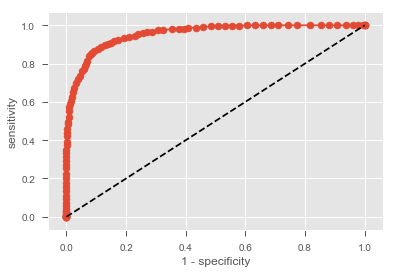

Threshold: 0.43
TP: 178
TN: 896
FP: 245
FN: 68
Accuracy: 0.77
Sensitivity: 0.72
Specificity: 0.79
AUC: 0.83


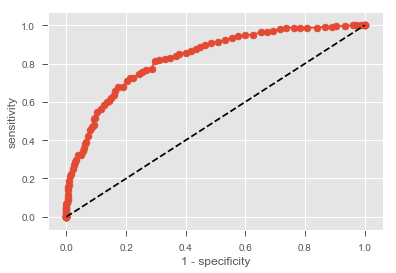

In [35]:
from sklearn.ensemble import RandomForestClassifier

print_ = 1
rf = RandomForestClassifier(n_estimators = 100, bootstrap=True, criterion='gini', 
                            max_depth = 10, min_samples_leaf = 10, random_state = 2)

# train the model on training data
rf.fit(X_train, y_train.values.ravel())

# tune - parameter estimation 
y_pred_prob_train = rf.predict_proba(X_train)
threshold, _, _, _ = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

# test
y_pred_class_test = rf.predict(X_test)
y_pred_prob_test = rf.predict_proba(X_test)
# The predicted class probability which is the fraction of samples of the same class in a leaf.

_, _, _, _ = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
# metrics.auc(fpr, tpr)

Compare above results with same RF without tuning the threshold.

Controlling the threshold allows us to achieve a better trade-off between sensitivity and specificity.

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class_test, pos_label=1)
auc = metrics.auc(fpr, tpr)
recall = metrics.recall_score(y_test, y_pred_class_test)
print('Sensitivity: ' + str(round(recall,2)))
print('Specificity: ' + str(round(1-fpr[1],2)))
print('AUC: ' + str(round(auc,2)))

Sensitivity: 0.61
Specificity: 0.86
AUC: 0.73


### 8.5.1. Feature importance

At each split in each tree, the improvement in the split-criterion ($G$) is the importance measure attributed to the splitting feature, and is accumulated over all the trees in the forest separately for each feature.

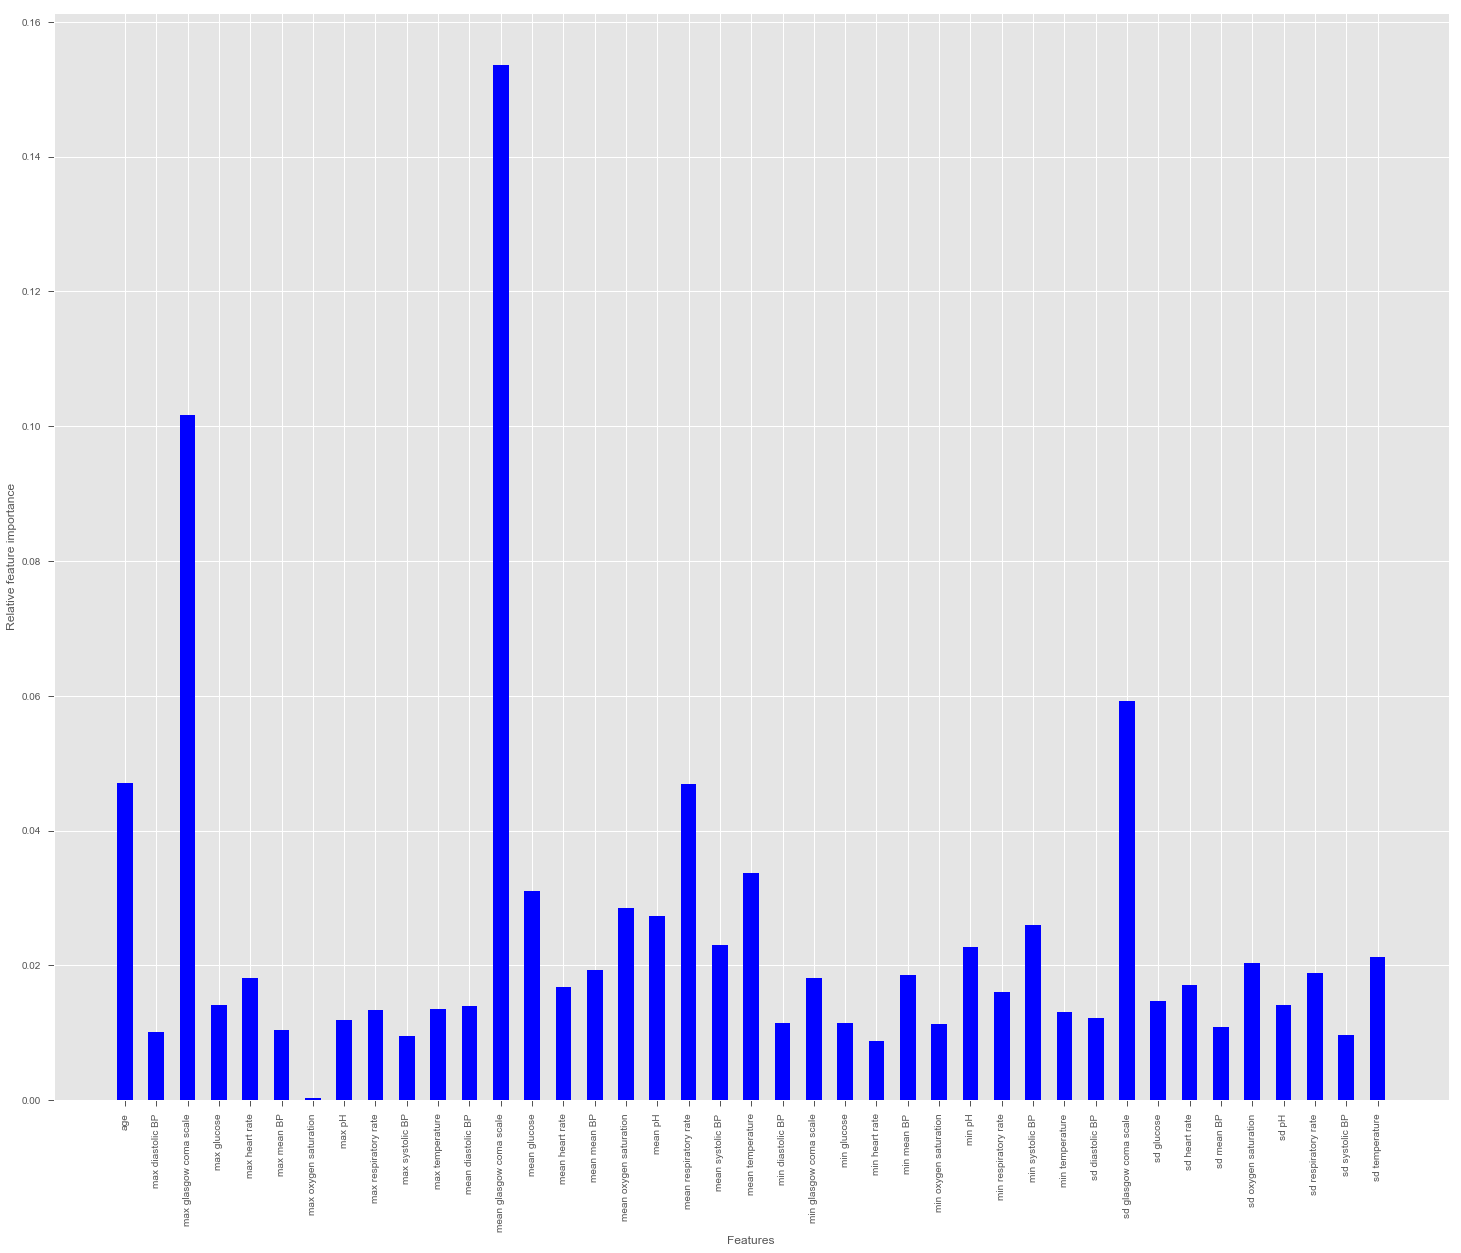

In [37]:
features = X_train.columns

#plt_x = np.linspace(0,len(features)-1,len(features))
#print("Features sorted by their score:")

list_feat = list(zip(features, rf.feature_importances_))
# print(sorted(list_feat))
pd_list_feat = pd.DataFrame(list_feat)
pd_list_feat.columns = ('Feature','Importance')
pd_list_feat = pd_list_feat.sort_values(by='Feature')
                      
plt.figure(figsize=(25,20))
plt.bar(range(len(features)),pd_list_feat['Importance'], width=0.5, color="blue",align='center')
plt.xticks(range(len(features)),pd_list_feat['Feature'], rotation='vertical')
plt.ylabel("Relative feature importance")
plt.xlabel("Features")
plt.grid(True)
plt.show()

# Exercises